In [2]:
'''
这个code的目的是用neurosketch 的数据来检测现在在realtime data里面发现的issue：也就是ceiling有时候竟然比floor更小
这个code的运行逻辑是
用neurosketch前五个run训练2 way classifiers，然后用最后一个run来计算ceiling和floor的值，看是否合理
'''


'''
purpose:
    find the best performed mask from the result of aggregate_greedy.py and save as chosenMask
    train all possible pairs of 2way classifiers and save for evidence calculation
    load saved classifiers and calculate different forms of evidence
steps:
    load the result of aggregate_greedy.py
    display the result of aggregate_greedy.py
    find the best performed ROI for each subject and display the accuracy of each subject, save the best performed ROI as chosenMask
    load the functional and behavior data and choseMask and train all possible pairs of 2way classifiers
    calculate the evidence floor and ceil for each subject and display different forms of evidences.
    

'''




'''
load the result of aggregate_greedy.py
'''
# To visualize the greedy result starting for 31 ROIs, in total 25 subjects.
import os
os.chdir("/gpfs/milgram/project/turk-browne/projects/rtTest/kp_scratch/")
from glob import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle5 as pickle
import subprocess
import numpy as np
import os
print(f"conda env={os.environ['CONDA_DEFAULT_ENV']}") 
import numpy as np
import nibabel as nib
import sys
import time
import pandas as pd
from sklearn.linear_model import LogisticRegression
import itertools
import pickle
import subprocess
from subprocess import call
import warnings
warnings.filterwarnings("ignore")

workingDir="/gpfs/milgram/project/turk-browne/projects/rtTest/"
def logit(p):
    return np.log(p/(1-p))
def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
roiloc="schaefer2018"
dataSource="neurosketch"
subjects_correctly_aligned=['1206161','0119173','1206162','1130161','1206163','0120171','0111171','1202161','0125172','0110172','0123173','0120173','0110171','0119172','0124171','0123171','1203161','0118172','0118171','0112171','1207162','0117171','0119174','0112173','0112172']
subjects=subjects_correctly_aligned
N=25
workingPath="/gpfs/milgram/project/turk-browne/projects/rtTest/"
GreedyBestAcc=np.zeros((len(subjects),N+1))
GreedyBestAcc[GreedyBestAcc==0]=None
GreedyBestAcc={}
numberOfROIs={}
for ii,subject in enumerate(subjects):
    # try:
    #     GreedyBestAcc[ii,N]=np.load(workingPath+"./{}/{}/output/uniMaskRanktag2_top{}.npy".format(roiloc, subject, N))
    # except:
    #     pass
    t=np.load(workingPath+"./{}/{}/output/uniMaskRanktag2_top{}.npy".format(roiloc, subject, N))
    GreedyBestAcc[subject]=[np.float(t)]
    numberOfROIs[subject]=[N]
    # for len_topN_1 in range(N-1,0,-1):
    for len_topN in range(1,N):
        # Wait(f"./tmp/{subject}_{N}_{roiloc}_{dataSource}_{len_topN_1}.pkl")
        try:
            # {当前的被试}_{greedy开始的ROI数目，也就是25}_{mask的种类schaefer2018}_{数据来源neurosketch}_{当前的 megaROI 包含有的数目}
            di = load_obj(f"./tmp__folder/{subject}_{N}_{roiloc}_{dataSource}_{len_topN}")
            GreedyBestAcc[subject].append(np.float(di['bestAcc']))
            numberOfROIs[subject].append(len_topN)
            # GreedyBestAcc[ii,len_topN] = di['bestAcc']
            
        except:
            pass


# '''
# to load the imtermediate results from greedy code to examine the system
# '''
# def wait(tmpFile):
#     while not os.path.exists(tmpFile+'_result.npy'):
#         time.sleep(5)
#         print(f"waiting for {tmpFile}_result.npy\n")
#     return np.load(tmpFile+'_result.npy')

# subject= '0119173' #sys.argv[1]
# sub_id = [i for i,x in enumerate(subjects) if x == subject][0]
# intermediate_result=np.zeros((N+1,N+1))
# # 应该有多少？25个24ROI，2个1ROI，24个
# for i in range(N,1,-1):
#     for j in range(i):
#         tmpFile=f"./tmp__folder/{subject}_{N}_{roiloc}_{dataSource}_{i}_{j}"
#         sl_result=wait(tmpFile)
#         intermediate_result[i,j]=sl_result

# # _=plt.imshow(intermediate_result)
# #最后一行是25个24ROI，第2行是2个1ROI

'''
display the result of aggregate_greedy.py
'''
# GreedyBestAcc=GreedyBestAcc.T
# plt.imshow(GreedyBestAcc)
# _=plt.figure()
# for i in range(GreedyBestAcc.shape[0]):
#     plt.scatter([i]*GreedyBestAcc.shape[1],GreedyBestAcc[i,:],c='g',s=2)
# plt.plot(np.arange(GreedyBestAcc.shape[0]),np.nanmean(GreedyBestAcc,axis=1))
# # plt.ylim([0.19,0.36])
# # plt.xlabel("number of ROIs")
# # plt.ylabel("accuracy")
# _=plt.figure()
# for j in range(GreedyBestAcc.shape[1]):
#     plt.plot(GreedyBestAcc[:,j])


# GreedyBestAcc=GreedyBestAcc.T
# _=plt.figure()
# plt.imshow(GreedyBestAcc)

'''
find the best performed ROI for each subject and display the accuracy of each subject, save the best performed ROI as chosenMask
'''
#find best ID for each subject
bestID={}
for ii,subject in enumerate(subjects):
    t=GreedyBestAcc[subject]
    bestID[subject] = numberOfROIs[subject][np.where(t==np.nanmax(t))[0][0]] #bestID 指的是每一个subject对应的最好的megaROI包含的ROI的数目
chosenMask={}
for subject in bestID:
    # best ID  
    # {当前的被试}_{greedy开始的ROI数目，也就是25}_{mask的种类schaefer2018}_{数据来源neurosketch}_{最好的megaROI 包含有的数目}
    di = load_obj(f"./tmp__folder/{subject}_{N}_{roiloc}_{dataSource}_{bestID[subject]}")
    chosenMask[subject] = di['bestROIs']

def getMask(topN, subject):
    workingDir="/gpfs/milgram/project/turk-browne/projects/rtTest/"
    for pn, parc in enumerate(topN):
        _mask = nib.load(workingDir+"/{}/{}/{}".format(roiloc, subject, parc))
        aff = _mask.affine
        _mask = _mask.get_data()
        _mask = _mask.astype(int)
        # say some things about the mask.
        mask = _mask if pn == 0 else mask + _mask
        mask[mask>0] = 1
    return mask

for sub in chosenMask:
    mask=getMask(chosenMask[sub], sub)
    # if not os.path.exists(f"{workingDir}/{roiloc}/{sub}/chosenMask.npy"):
    np.save(f"{workingDir}/{roiloc}/{sub}/chosenMask",mask)
    

from scipy.stats import zscore
def normalize(X):
    _X=X.copy()
    _X = zscore(_X, axis=0)
    _X[np.isnan(_X)]=0
    return _X

def mkdir(folder):
    if not os.path.isdir(folder):
        os.mkdir(folder)

'''
calculate the evidence floor and ceil for each subject and display different forms of evidences.
'''
def morphingTarget(subject,testRun=6):
    '''
    purpose:
        get the morphing target function
    steps:
        load train clf
        load brain data and behavior data
        get the morphing target function
            evidence_floor is C evidence for CD classifier(can also be D evidence for CD classifier)
            evidence_ceil  is A evidence in AC and AD classifier
    '''

    import os
    import numpy as np
    import pandas as pd
    import joblib
    import nibabel as nib


    phasedict = dict(zip([1,2,3,4,5,6],["12", "12", "34", "34", "56", "56"]))
    imcodeDict={"A": "bed", "B": "Chair", "C": "table", "D": "bench"}
    if 'milgram' in os.getcwd():
        main_dir='/gpfs/milgram/project/turk-browne/projects/rtTest/'
    else:
        main_dir='/Users/kailong/Desktop/rtTest'

    working_dir=main_dir
    os.chdir(working_dir)

    funcdata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/{sub}_neurosketch/data/nifti/realtime_preprocessed/{sub}_neurosketch_recognition_run_{run}.nii.gz"
    metadata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/data/features/recog/metadata_{sub}_V1_{phase}.csv"

    metas = []

    run=testRun
    print(run, end='--')
    # retrieve from the dictionary which phase it is, assign the session
    phase = phasedict[run]
    ses = 1
    
    # Build the path for the preprocessed functional data
    this4d = funcdata.format(ses=ses, run=run, phase=phase, sub=subject)
    
    # Read in the metadata, and reduce it to only the TR values from this run, add to a list
    thismeta = pd.read_csv(metadata.format(ses=ses, run=run, phase=phase, sub=subject))
    if dataSource == "neurosketch":
        _run = 1 if run % 2 == 0 else 2
    else:
        _run = run
    thismeta = thismeta[thismeta['run_num'] == int(_run)]
    
    if dataSource == "realtime":
        TR_num = list(thismeta.TR.astype(int))
        labels = list(thismeta.Item)
        labels = [imcodeDict[label] for label in labels]
    else:
        TR_num = list(thismeta.TR_num.astype(int))
        labels = list(thismeta.label)
    
    print("LENGTH OF TR: {}".format(len(TR_num)))
    # Load the functional data
    runIm = nib.load(this4d)
    affine_mat = runIm.affine
    runImDat = runIm.get_fdata()
    
    # Use the TR numbers to select the correct features
    features = [runImDat[:,:,:,n+3] for n in TR_num]
    features = np.array(features)
    chosenMask = np.load(f"/gpfs/milgram/project/turk-browne/projects/rtTest/schaefer2018/{subject}/chosenMask.npy")
    features = features[:, chosenMask==1]
    print("shape of features", features.shape, "shape of mask", mask.shape)
    # featmean = features.mean(1).mean(1).mean(1)[..., None,None,None] #features.mean(1)[..., None]
    # features = features - featmean
    # features = features - features.mean(0)
    features = normalize(features)
    # features = np.expand_dims(features, 0)
    
    # Append both so we can use it later
    # metas.append(labels)
    # metas['label']

    t=pd.DataFrame()
    t['label']=labels
    t["run_num"]=run
    behav_data=t
    
    runs = features

    
    dimsize = runIm.header.get_zooms()
    
    brain_data = runs
    print(brain_data.shape)
    print(behav_data.shape)
    FEAT=brain_data
    print(f"FEAT.shape={FEAT.shape}")
    META=behav_data

    # convert item colume to label colume
    imcodeDict={
    'A': 'bed',
    'B': 'chair',
    'C': 'table',
    'D': 'bench'}


    # def classifierEvidence(clf,X,Y):
    #     ID=np.where((clf.classes_==Y)*1==1)[0][0]
    #     Evidence=(X@clf.coef_.T+clf.intercept_) if ID==1 else (-(X@clf.coef_.T+clf.intercept_))
    #     # Evidence=(X@clf.coef_.T+clf.intercept_) if ID==0 else (-(X@clf.coef_.T+clf.intercept_))
    #     return np.asarray(Evidence)

    # def classifierEvidence(clf,X,Y):
    #     ID=np.where((clf.classes_==Y)*1==1)[0][0]
    #     p = clf.predict_proba(X)[:,ID]
    #     BX=np.log(p/(1-p))
    #     return BX

    def classifierProb(clf,X,Y):
        ID=np.where((clf.classes_==Y)*1==1)[0][0]
        p = clf.predict_proba(X)[:,ID]
        return p

    A_ID = (META['label']=='bed')
    X = FEAT[A_ID]


    model_folder = f"{working_dir}{roiloc}/{subject}/clf/"

    store="\n"
    print("floor")
    # D evidence for AD_clf when A is presented.
    Y = 'bench'
    AD_clf=joblib.load(model_folder +'bedchair_bedbench.joblib') # These 4 clf are the same:   bedchair_bedbench.joblib bedtable_bedbench.joblib benchchair_benchbed.joblib benchtable_benchbed.joblib
    AD_D_evidence = classifierProb(AD_clf,X,Y)
    evidence_floor = np.mean(AD_D_evidence)
    print(f"D evidence for AD_clf when A is presented={evidence_floor}")
    store=store+f"D evidence for AD_clf when A is presented={evidence_floor}"

    # C evidence for AC_clf when A is presented.
    Y = 'table'
    AC_clf=joblib.load(model_folder +'benchtable_tablebed.joblib') # These 4 clf are the same:   bedbench_bedtable.joblib bedchair_bedtable.joblib benchtable_tablebed.joblib chairtable_tablebed.joblib
    AC_C_evidence = classifierProb(AC_clf,X,Y)
    evidence_floor = np.mean(AC_C_evidence)
    print(f"C evidence for AC_clf when A is presented={evidence_floor}")
    store=store+"\n"+f"C evidence for AC_clf when A is presented={evidence_floor}"

    # D evidence for CD_clf when A is presented.
    Y = 'bench'
    CD_clf=joblib.load(model_folder +'bedbench_benchtable.joblib') # These 4 clf are the same: bedbench_benchtable.joblib bedtable_tablebench.joblib benchchair_benchtable.joblib chairtable_tablebench.joblib
    CD_D_evidence = classifierProb(CD_clf,X,Y)
    evidence_floor1 = np.mean(CD_D_evidence)
    print(f"D evidence for CD_clf when A is presented={evidence_floor1}")
    store=store+"\n"+f"D evidence for CD_clf when A is presented={evidence_floor1}"

    # C evidence for CD_clf when A is presented.
    Y = 'table'
    CD_clf=joblib.load(model_folder +'bedbench_benchtable.joblib') # These 4 clf are the same: bedbench_benchtable.joblib bedtable_tablebench.joblib benchchair_benchtable.joblib chairtable_tablebench.joblib
    CD_C_evidence = classifierProb(CD_clf,X,Y)
    evidence_floor2 = np.mean(CD_C_evidence)
    print(f"C evidence for CD_clf when A is presented={evidence_floor2}")
    store=store+"\n"+f"C evidence for CD_clf when A is presented={evidence_floor2}"

    # set floor to be 0, (aka before inverting is 0.5) and only estimate ceiling # edited 03152021
    evidence_floor = 0.5 #max(evidence_floor1,evidence_floor2)
    store=store+f"\nmax(evidence_floor1,evidence_floor2)={evidence_floor} unique_Mark"


    print("ceil")
    store=store+"\n"+"ceil"
    # evidence_ceil  is A evidence in AC and AD classifier
    Y = 'bed'
    AC_clf=joblib.load(model_folder +'benchtable_tablebed.joblib') # These 4 clf are the same:   bedbench_bedtable.joblib bedchair_bedtable.joblib benchtable_tablebed.joblib chairtable_tablebed.joblib
    AC_A_evidence = classifierProb(AC_clf,X,Y)
    evidence_ceil1 = AC_A_evidence
    print(f"A evidence in AC_clf when A is presented={np.mean(evidence_ceil1)}")
    store=store+"\n"+f"A evidence in AC_clf when A is presented={np.mean(evidence_ceil1)}"

    Y = 'bed'
    AD_clf=joblib.load(model_folder +'bedchair_bedbench.joblib') # These 4 clf are the same:   bedchair_bedbench.joblib bedtable_bedbench.joblib benchchair_benchbed.joblib benchtable_benchbed.joblib
    AD_A_evidence = classifierProb(AD_clf,X,Y)
    evidence_ceil2 = AD_A_evidence
    print(f"A evidence in AD_clf when A is presented={np.mean(evidence_ceil2)}")
    store=store+"\n"+f"A evidence in AD_clf when A is presented={np.mean(evidence_ceil2)}"

    # evidence_ceil = np.mean(evidence_ceil1)
    # evidence_ceil = np.mean(evidence_ceil2)
    evidence_ceil = np.mean((evidence_ceil1+evidence_ceil2)/2)
    print(f"evidence_ceil={evidence_ceil} uniqueMark")
    store=store+f"\nevidence_ceil={evidence_ceil} uniqueMark"

    # ceil,floor=logit(evidence_ceil),logit(evidence_floor)
    # mu = (ceil+floor)/2
    # sig = (ceil-floor)/2.3548
    # print(f"floor={floor}, ceil={ceil}")
    # print(f"mu={mu}, sig={sig}")

    # store=store+"\n"+f"floor={floor}, ceil={ceil}"
    # store=store+"\n"+f"mu={mu}, sig={sig}"


    # BC_clf=joblib.load(model_folder +'benchchair_chairtable.joblib') # These 4 clf are the same: bedbench_benchtable.joblib bedtable_tablebench.joblib benchchair_benchtable.joblib chairtable_tablebench.joblib
    # BD_clf=joblib.load(model_folder +'bedchair_chairbench.joblib') # These 4 clf are the same: bedbench_benchtable.joblib bedtable_tablebench.joblib benchchair_benchtable.joblib chairtable_tablebench.joblib
    # Y = 'chair'
    # # imcodeDict={
    # # 'A': 'bed',
    # # 'B': 'chair',
    # # 'C': 'table',
    # # 'D': 'bench'}
    # print(f"classifierProb(BC_clf,FEAT,Y)={classifierProb(BC_clf,FEAT,Y)}")
    # print(f"classifierProb(BD_clf,FEAT,Y)={classifierProb(BD_clf,FEAT,Y)}")


    # # # convert item colume to label colume
    # # imcodeDict={
    # # 'A': 'bed',
    # # 'B': 'chair',
    # # 'C': 'table',
    # # 'D': 'bench'}
    # def testMorphParamFor(A): #A='bed''chair'...
    #     A_ID = (META['label']==A)
    #     X = FEAT[A_ID]


    #     # 这里的X是选择的testRun里面的所有的展示A的trials
    #     BC_B_evidence = classifierProb(BC_clf,X,Y)
    #     BD_B_evidence = classifierProb(BD_clf,X,Y)
    #     print(f"BC_B_evidence={BC_B_evidence}")
    #     print(f"BD_B_evidence={BD_B_evidence}")
    #     B_evidence = (BC_B_evidence+BD_B_evidence)/2
    #     print(f"B_evidence={B_evidence}")
    #     print(f"mu={mu}, sig={sig}")
        



    #     def gaussian(x, mu, sig):
    #         # mu and sig is determined before each neurofeedback session using 2 recognition runs.
    #         return np.round(1+18*(1 - np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.))))) # map from (-∞,∞) -> [1,19]
    #     morphParam=np.mean(gaussian(B_evidence, mu, sig))
    #     # B_evidences.append(B_evidence)
    #     print(f"morphParam={morphParam}")
    #     return f"morphParam for {A} = {morphParam}"

    # store=store+"\n"+testMorphParamFor('bed')
    # store=store+"\n"+testMorphParamFor('chair')
    # store=store+"\n"+testMorphParamFor('table')
    # store=store+"\n"+testMorphParamFor('bench')

    return evidence_floor, evidence_ceil,store



'''
load the functional and behavior data and choseMask and train all possible pairs of 2way classifiers
''' 
def minimalClass(subject):
    # subject=subjects[1]
    '''
    purpose: 
        train offline models

    steps:
        load preprocessed and aligned behavior and brain data 
        select data with the wanted pattern like AB AC AD BC BD CD 
        train correspondng classifier and save the classifier performance and the classifiers themselves.

    '''

    import os
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import sklearn
    import joblib
    import nibabel as nib
    import itertools
    from sklearn.linear_model import LogisticRegression

    def gaussian(x, mu, sig):
        # mu and sig is determined before each neurofeedback session using 2 recognition runs.
        return round(1+18*(1 - np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.))))) # map from (0,1) -> [1,19]

    def jitter(size,const=0):
        jit = np.random.normal(0+const, 0.05, size)
        X = np.zeros((size))
        X = X + jit
        return X

    def other(target):
        other_objs = [i for i in ['bed', 'bench', 'chair', 'table'] if i not in target]
        return other_objs

    def red_vox(n_vox, prop=0.1):
        return int(np.ceil(n_vox * prop))

    def get_inds(X, Y, pair, testRun=None):

        inds = {}

        # return relative indices
        if testRun:
            trainIX = Y.index[(Y['label'].isin(pair)) & (Y['run_num'] != int(testRun))]
        else:
            trainIX = Y.index[(Y['label'].isin(pair))]

        # pull training and test data
        trainX = X[trainIX]
        trainY = Y.iloc[trainIX].label

        # Main classifier on 5 runs, testing on 6th
        clf = LogisticRegression(penalty='l2',C=1, solver='lbfgs', max_iter=1000, 
                                multi_class='multinomial').fit(trainX, trainY)
        B = clf.coef_[0]  # pull betas

        # retrieve only the first object, then only the second object
        if testRun:
            obj1IX = Y.index[(Y['label'] == pair[0]) & (Y['run_num'] != int(testRun))]
            obj2IX = Y.index[(Y['label'] == pair[1]) & (Y['run_num'] != int(testRun))]
        else:
            obj1IX = Y.index[(Y['label'] == pair[0])]
            obj2IX = Y.index[(Y['label'] == pair[1])]

        # Get the average of the first object, then the second object
        obj1X = np.mean(X[obj1IX], 0)
        obj2X = np.mean(X[obj2IX], 0)

        # Build the importance map
        mult1X = obj1X * B
        mult2X = obj2X * B

        # Sort these so that they are from least to most important for a given category.
        sortmult1X = mult1X.argsort()[::-1]
        sortmult2X = mult2X.argsort()

        # add to a dictionary for later use
        inds[clf.classes_[0]] = sortmult1X
        inds[clf.classes_[1]] = sortmult2X

        return inds

    if 'milgram' in os.getcwd():
        main_dir='/gpfs/milgram/project/turk-browne/projects/rtTest/'
    else:
        main_dir='/Users/kailong/Desktop/rtTest'

    working_dir=main_dir
    os.chdir(working_dir)

    objects = ['bed', 'bench', 'chair', 'table']


    if dataSource == "neurosketch":
        funcdata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/{sub}_neurosketch/data/nifti/realtime_preprocessed/{sub}_neurosketch_recognition_run_{run}.nii.gz"
        metadata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/data/features/recog/metadata_{sub}_V1_{phase}.csv"
        anat = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/{sub}_neurosketch/data/nifti/{sub}_neurosketch_anat_mprage_brain.nii.gz"
    elif dataSource == "realtime":
        funcdata = "/gpfs/milgram/project/turk-browne/projects/rtcloud_kp/subjects/{sub}/ses{ses}_recognition/run0{run}/nifti/{sub}_functional.nii.gz"
        metadata = "/gpfs/milgram/project/turk-browne/projects/rtcloud_kp/subjects/{sub}/ses{ses}_recognition/run0{run}/{sub}_0{run}_preprocessed_behavData.csv"
        anat = "$TO_BE_FILLED"
    else:
        funcdata = "/gpfs/milgram/project/turk-browne/projects/rtTest/searchout/feat/{sub}_pre.nii.gz"
        metadata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/data/features/recog/metadata_{sub}_V1_{phase}.csv"
        anat = "$TO_BE_FILLED"

    # print('mask dimensions: {}'. format(mask.shape))
    # print('number of voxels in mask: {}'.format(np.sum(mask)))
    phasedict = dict(zip([1,2,3,4,5,6],["12", "12", "34", "34", "56", "56"]))
    imcodeDict={"A": "bed", "B": "Chair", "C": "table", "D": "bench"}
    chosenMask = np.load(f"/gpfs/milgram/project/turk-browne/projects/rtTest/schaefer2018/{subject}/chosenMask.npy")
    print(f"np.sum(chosenMask)={np.sum(chosenMask)}")
    # Compile preprocessed data and corresponding indices
    metas = []
    for run in range(1, 7):
        print(run, end='--')
        # retrieve from the dictionary which phase it is, assign the session
        phase = phasedict[run]
        
        # Build the path for the preprocessed functional data
        this4d = funcdata.format(run=run, phase=phase, sub=subject)
        
        # Read in the metadata, and reduce it to only the TR values from this run, add to a list
        thismeta = pd.read_csv(metadata.format(run=run, phase=phase, sub=subject))
        if dataSource == "neurosketch":
            _run = 1 if run % 2 == 0 else 2
        else:
            _run = run
        thismeta = thismeta[thismeta['run_num'] == int(_run)]
        
        if dataSource == "realtime":
            TR_num = list(thismeta.TR.astype(int))
            labels = list(thismeta.Item)
            labels = [imcodeDict[label] for label in labels]
        else:
            TR_num = list(thismeta.TR_num.astype(int))
            labels = list(thismeta.label)
        
        print("LENGTH OF TR: {}".format(len(TR_num)))
        # Load the functional data
        runIm = nib.load(this4d)
        affine_mat = runIm.affine
        runImDat = runIm.get_fdata()
        
        # Use the TR numbers to select the correct features
        features = [runImDat[:,:,:,n+3] for n in TR_num] # here shape is from (94, 94, 72, 240) to (80, 94, 94, 72)
        features = np.array(features)
        features = features[:, chosenMask==1]
        print("shape of features", features.shape, "shape of chosenMask", chosenMask.shape)
        features = normalize(features)
        # features = np.expand_dims(features, 0)
        
        # Append both so we can use it later
        # metas.append(labels)
        # metas['label']

        t=pd.DataFrame()
        t['label']=labels
        t["run_num"]=run
        behav_data=t if run==1 else pd.concat([behav_data,t])
        
        runs = features if run == 1 else np.concatenate((runs, features))

    dimsize = runIm.header.get_zooms()
    brain_data = runs
    print(brain_data.shape)
    print(behav_data.shape)
    FEAT=brain_data
    print(f"FEAT.shape={FEAT.shape}")
    META=behav_data

    def Class(brain_data,behav_data):
        accs = []
        for run in range(1,7):
            trainIX = behav_data['run_num']!=int(run)
            testIX = behav_data['run_num']==int(run)

            trainX =  brain_data[trainIX]
            trainY =  behav_data.iloc[np.asarray(trainIX)].label

            testX =  brain_data[testIX]
            testY =  behav_data.iloc[np.asarray(testIX)].label

            clf = LogisticRegression(penalty='l2',C=1, solver='lbfgs', max_iter=1000, 
                                    multi_class='multinomial').fit(trainX, trainY)

            # Monitor progress by printing accuracy (only useful if you're running a test set)
            acc = clf.score(testX, testY)
            accs.append(acc)
        accs
        return np.mean(accs)
    accs=Class(brain_data,behav_data)
    print(f"new trained 4 way classifier accuracy={accs}")


    # convert item colume to label colume
    imcodeDict={
    'A': 'bed',
    'B': 'chair',
    'C': 'table',
    'D': 'bench'}

    # Which run to use as test data (leave as None to not have test data)
    accs_rotation_container={}
    evidence_rotation_container={}
    for testRun in range(1,7):
        # testRun = 6 # when testing: testRun = 2 ; META['run_num'].iloc[:5]=2

        # Decide on the proportion of crescent data to use for classification
        include = 1
        objects = ['bed', 'bench', 'chair', 'table']
        allpairs = itertools.combinations(objects,2)
        accs={}
        # Iterate over all the possible target pairs of objects
        for pair in allpairs:
            # Find the control (remaining) objects for this pair
            altpair = other(pair)

            # pull sorted indices for each of the critical objects, in order of importance (low to high)
            # inds = get_inds(FEAT, META, pair, testRun=testRun)

            # Find the number of voxels that will be left given your inclusion parameter above
            # nvox = red_vox(FEAT.shape[1], include)

            for obj in pair:
                # foil = [i for i in pair if i != obj][0]
                for altobj in altpair:

                    # establish a naming convention where it is $TARGET_$CLASSIFICATION
                    # Target is the NF pair (e.g. bed/bench)
                    # Classificationis is btw one of the targets, and a control (e.g. bed/chair, or bed/table, NOT bed/bench)
                    naming = '{}{}_{}{}'.format(pair[0], pair[1], obj, altobj)

                    # Pull the relevant inds from your previously established dictionary 
                    # obj_inds = inds[obj]

                    # If you're using testdata, this function will split it up. Otherwise it leaves out run as a parameter
                    # if testRun:
                    #     trainIX = META.index[(META['label'].isin([obj, altobj])) & (META['run_num'] != int(testRun))]
                    #     testIX = META.index[(META['label'].isin([obj, altobj])) & (META['run_num'] == int(testRun))]
                    # else:
                    #     trainIX = META.index[(META['label'].isin([obj, altobj]))]
                    #     testIX = META.index[(META['label'].isin([obj, altobj]))]
                    # # pull training and test data
                    # trainX = FEAT[trainIX]
                    # testX = FEAT[testIX]
                    # trainY = META.iloc[trainIX].label
                    # testY = META.iloc[testIX].label

                    # print(f"obj={obj},altobj={altobj}")
                    # print(f"unique(trainY)={np.unique(trainY)}")
                    # print(f"unique(testY)={np.unique(testY)}")
                    # assert len(np.unique(trainY))==2

                    # for testRun in range(6):
                    if testRun:
                        trainIX = ((META['label']==obj) + (META['label']==altobj)) * (META['run_num']!=int(testRun))
                        testIX = ((META['label']==obj) + (META['label']==altobj)) * (META['run_num']==int(testRun))
                    else:
                        trainIX = ((META['label']==obj) + (META['label']==altobj))
                        testIX = ((META['label']==obj) + (META['label']==altobj))
                    # pull training and test data
                    trainX = FEAT[trainIX]
                    testX = FEAT[testIX]
                    trainY = META.iloc[np.asarray(trainIX)].label
                    testY = META.iloc[np.asarray(testIX)].label

                    # print(f"obj={obj},altobj={altobj}")
                    # print(f"unique(trainY)={np.unique(trainY)}")
                    # print(f"unique(testY)={np.unique(testY)}")
                    assert len(np.unique(trainY))==2

                    # # If you're selecting high-importance features, this bit handles that
                    # if include < 1:
                    #     trainX = trainX[:, obj_inds[-nvox:]]
                    #     testX = testX[:, obj_inds[-nvox:]]

                    # Train your classifier
                    clf = LogisticRegression(penalty='l2',C=1, solver='lbfgs', max_iter=1000, 
                                            multi_class='multinomial').fit(trainX, trainY)


                    model_folder = f"{working_dir}{roiloc}/{subject}/clf/"
                    mkdir(model_folder)
                    # Save it for later use
                    joblib.dump(clf, model_folder +'/{}.joblib'.format(naming))

                    # Monitor progress by printing accuracy (only useful if you're running a test set)
                    acc = clf.score(testX, testY)
                    # print(naming, acc)
                    accs[naming]=acc
        accs_rotation_container[testRun] = accs
        evidence_rotation_container[testRun] = morphingTarget(subject,testRun=testRun)
    # for testRun in range(1,7):
    #     t=np.mean(list(accs_rotation_container[testRun].values()))
    #     print(f"testRun {testRun} mean testing accracy={t}")
    #     print(evidence_rotation_container[testRun][2])
    def getString(string,searchFor,end):
        return string.split(searchFor)[1].split(end)[0]
    # getString(string,searchFor)

    # floors=[]
    # ceils=[]
    # for testRun in range(1,7):
    #     t=np.mean(list(accs_rotation_container[testRun].values()))
    #     print(f"testRun {testRun} mean testing accracy={t}")
    #     # print(evidence_rotation_container[testRun][2])
    #     t=np.float(getString(evidence_rotation_container[testRun][2],"\nmax(evidence_floor1,evidence_floor2)="," unique_Mark"))
    #     print("floor=",t)
    #     floors.append(t)
        
    #     t=np.float(getString(evidence_rotation_container[testRun][2],"\nevidence_ceil="," uniqueMark"))
    #     print("ceiling=",t)
    #     ceils.append(t)
    #     print()
    #     print()
    # print(np.mean(floors))
    # print(np.mean(ceils))

    # _=plt.figure()
    # _=plt.hist(list(accs.values()))
    return accs_rotation_container , evidence_rotation_container



    


# subject= '0119173' #sys.argv[1]
# sub_id = [i for i,x in enumerate(subjects) if x == subject][0]





def subLoop(subject):
    accs_rotation_container , evidence_rotation_container = minimalClass(subject)
    # print("best 4way classifier accuracy = ",GreedyBestAcc[subject][bestID[subject]])
    # data['best 4way classifier accuracy']=GreedyBestAcc[subject][bestID[subject]]
    # for acc in accs:
    #     print(acc,accs[acc])
    # # data["accs"]=accs
    # # floor, ceil,store = morphingTarget(subject,testRun=6)
    # # data["store testing run"]=store
    # # floor, ceil,store = morphingTarget(subject,testRun=1)
    # # data["store training run"]=store
    
    # save_obj(store,f"./{subject}store")
    return accs_rotation_container , evidence_rotation_container


from tqdm import tqdm
data={}
for subject in tqdm(subjects):
    data[subject]=subLoop(subject)

def getString(string,searchFor,end):
    return string.split(searchFor)[1].split(end)[0]

def getCeilFLoor(a):
    accs_rotation_container , evidence_rotation_container = a

    floors=[]
    ceils=[]
    for testRun in range(1,7):
        t=np.float(getString(evidence_rotation_container[testRun][2],"\\nmax(evidence_floor1,evidence_floor2)="," unique_Mark"))
        floors.append(t)
        t=np.float(getString(evidence_rotation_container[testRun][2],"\nevidence_ceil="," uniqueMark"))
        ceils.append(t)

    print(logit(np.mean(floors)))
    print(logit(np.mean(ceils)))
    return logit(np.mean(floors)),logit(np.mean(ceils))

floors=[]
ceilings=[]
for subject in subjects:
    floor,ceiling = getCeilFLoor(data[subject])
    floors.append(floor)
    ceilings.append(ceiling)

plt.plot(floors,label='floor')
plt.plot(ceilings,label="ceiling")
plt.legend()
plt.xlabel("subjects")
plt.ylabel("evidence")



# # floorCeilNeurosketch_child.sh
# #!/usr/bin/env bash
# # Input python command to be submitted as a job
# #SBATCH --output=logs/floorCeil-%j.out
# #SBATCH --job-name floorCeil
# #SBATCH --partition=short,day,scavenge,verylong
# #SBATCH --time=1:00:00 #20:00:00
# #SBATCH --mem=10000
# #SBATCH -n 5

# # Set up the environment

# subject=$1

# echo source activate /gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud
# source activate /gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud

# python -u ./floorCeilNeurosketch.py $subject




# # floorCeilNeurosketch_parent.sh
# subjects="1206161 0119173 1206162 1130161 1206163 0120171 0111171 1202161 0125172 0110172 0123173 0120173 0110171 0119172 0124171 0123171 1203161 0118172 0118171 0112171 1207162 0117171 0119174 0112173 0112172" #these subjects are done with the batchRegions code
# for sub in $subjects
# do
#   for num in 25; #best ID is 30 thus the best num is 31
#   do
#     echo sbatch --requeue floorCeilNeurosketch_child.sh $sub
#     sbatch --requeue floorCeilNeurosketch_child.sh $sub
#   done
# done


conda env=/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud


FileNotFoundError: [Errno 2] No such file or directory: './tmp__folder/1206161_25_schaefer2018_neurosketch_25.pkl'

In [21]:
def getString(string,searchFor,end):
    searchFor="\nmax(evidence_floor1,evidence_floor2)="
    print(f"searchFor={searchFor}")
    
    print(f"string={len(string)}")
    end="unique_Mark"
    print(f"end={end}")
    print(f"string.split(searchFor)={string.split(searchFor)}")
    return string.split(searchFor)[1].split(end)[0]

subject=subjects[0]
getCeilFLoor(data[subject])

searchFor=
max(evidence_floor1,evidence_floor2)=
string=468
end=unique_Mark
string.split(searchFor)=['\nD evidence for AD_clf when A is presented=0.4301477965026425\nC evidence for AC_clf when A is presented=0.44626260592632655\nD evidence for CD_clf when A is presented=0.43046667837478136\nC evidence for CD_clf when A is presented=0.5695333216252185', '0.5 unique_Mark\nceil\nA evidence in AC_clf when A is presented=0.5537373940736734\nA evidence in AD_clf when A is presented=0.5698522034973574\nevidence_ceil=0.5617947987855155 uniqueMark']
searchFor=
max(evidence_floor1,evidence_floor2)=
string=468
end=unique_Mark
string.split(searchFor)=['\nD evidence for AD_clf when A is presented=0.4301477965026425\nC evidence for AC_clf when A is presented=0.44626260592632655\nD evidence for CD_clf when A is presented=0.43046667837478136\nC evidence for CD_clf when A is presented=0.5695333216252185', '0.5 unique_Mark\nceil\nA evidence in AC_clf when A is presented=0.5537373940736734\nA evidence in

(0.0, 0.0)

0.0
0.13509416919982745
0.0
0.01313386824811581
0.0
0.057160505556830624
0.0
0.031352781250163796
0.0
0.18324182654387153
0.0
0.0677463436615452
0.0
0.25125947893986095
0.0
0.23111024316441645
0.0
0.14397156291203445
0.0
0.16050659175261547
0.0
0.3086527142567104
0.0
0.1892737127258979
0.0
0.14190224522165298
0.0
0.2625404132808702
0.0
0.04457331000554807
0.0
0.08985353750693209
0.0
0.16289872046366713
0.0
0.08743586462732472
0.0
0.023156988416894283
0.0
0.2364679601189887
0.0
0.07625819233726781
0.0
0.3421608817415616
0.0
0.2841203239286231
0.0
0.05962434102268033
0.0
0.2315635936201434


Text(0, 0.5, 'evidence')

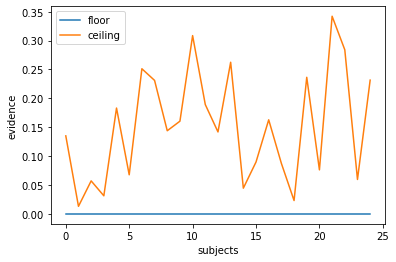

In [22]:

def getString(string,searchFor,end):
    return string.split(searchFor)[1].split(end)[0]

def getCeilFLoor(a):
    accs_rotation_container , evidence_rotation_container = a

    floors=[]
    ceils=[]
    for testRun in range(1,7):
        t=np.float(getString(evidence_rotation_container[testRun][2],"max(evidence_floor1,evidence_floor2)=","unique_Mark"))
        floors.append(t)
        t=np.float(getString(evidence_rotation_container[testRun][2],"evidence_ceil=","uniqueMark"))
        ceils.append(t)

    print(logit(np.mean(floors)))
    print(logit(np.mean(ceils)))
    return logit(np.mean(floors)),logit(np.mean(ceils))

floors=[]
ceilings=[]
for subject in subjects:
    floor,ceiling = getCeilFLoor(data[subject])
    floors.append(floor)
    ceilings.append(ceiling) 

plt.plot(floors,label='floor')
plt.plot(ceilings,label="ceiling")
plt.legend()
plt.xlabel("subjects")
plt.ylabel("evidence")

In [27]:
import os
subjects="1206161 0119173 1206162 1130161 1206163 0120171 0111171 1202161 0125172 0110172 0123173 0120173 0110171 0119172 0124171 0123171 1203161 0118172 0118171 0112171 1207162 0117171 0119174 0112173 0112172"
subjects=subjects.split(" ")
a=[]
for sub in subjects:
    if os.path.exists(f"/gpfs/milgram/project/turk-browne/projects/rtTest/schaefer2018/{sub}/GM_96.nii.gz"):
        print(sub)
    else:
        a.append(sub)
        
print(len(a))
print(len(subjects))

1206161
0119173
1206163
0120171
0111171
1202161
0125172
0110172
0123173
0120173
0110171
0119172
0124171
0123171
1203161
0118172
0118171
0112171
1207162
0117171
0119174
0112173
0112172
2
25


In [29]:
a #1206162已经跑了  
# sbatch SUMA_Make_Spec_FS.sh 1130161

['1206162', '1130161']

In [12]:
noGM="""0.0
0.13509416919982745
0.0
0.01313386824811581
0.0
0.057160505556830624
0.0
0.031352781250163796
0.0
0.18324182654387153
0.0
0.0677463436615452
0.0
0.25125947893986095
0.0
0.23111024316441645
0.0
0.14397156291203445
0.0
0.16050659175261547
0.0
0.3086527142567104
0.0
0.1892737127258979
0.0
0.14190224522165298
0.0
0.2625404132808702
0.0
0.04457331000554807
0.0
0.08985353750693209
0.0
0.16289872046366713
0.0
0.08743586462732472
0.0
0.023156988416894283
0.0
0.2364679601189887
0.0
0.07625819233726781
0.0
0.3421608817415616
0.0
0.2841203239286231
0.0
0.05962434102268033
0.0
0.2315635936201434
"""
NoGM=[0.13509416919982745]
stringList=noGM.split("\n0.0\n")
for i in range(1,len(stringList)):    
    NoGM.append(float(stringList[i]))
NoGM

[0.13509416919982745,
 0.01313386824811581,
 0.057160505556830624,
 0.031352781250163796,
 0.18324182654387153,
 0.0677463436615452,
 0.25125947893986095,
 0.23111024316441645,
 0.14397156291203445,
 0.16050659175261547,
 0.3086527142567104,
 0.1892737127258979,
 0.14190224522165298,
 0.2625404132808702,
 0.04457331000554807,
 0.08985353750693209,
 0.16289872046366713,
 0.08743586462732472,
 0.023156988416894283,
 0.2364679601189887,
 0.07625819233726781,
 0.3421608817415616,
 0.2841203239286231,
 0.05962434102268033,
 0.2315635936201434]

In [13]:
GM_s="""0.0
0.1704018019671017
0.0
0.015473825479978038
0.0
0.156277891292176
0.0
0.1234585334065389
0.0
0.23871839204563827
0.0
0.09837705349563342
0.0
0.23528731137622036
0.0
0.23130485589191493
0.0
0.13846164383941578
0.0
0.23388283785077046
0.0
0.20108707419544591
0.0
0.1512688639136599
0.0
0.02098889405777557
0.0
0.40217563355892294
0.0
0.15899675598518231
0.0
0.10188696143122584
0.0
0.19378255742049785
0.0
0.24137653795983605
0.0
0.15063441599697375
0.0
0.1675121356064939
0.0
0.2332026859351661
0.0
0.10311784816750072
0.0
0.03493032693679105
0.0
0.3324759723502478
0.0
0.08287185584068701
"""
GM=[0.1704018019671017]
stringList=GM_s.split("\n0.0\n")
for i in range(1,len(stringList)):    
    GM.append(float(stringList[i]))
GM

[0.1704018019671017,
 0.015473825479978038,
 0.156277891292176,
 0.1234585334065389,
 0.23871839204563827,
 0.09837705349563342,
 0.23528731137622036,
 0.23130485589191493,
 0.13846164383941578,
 0.23388283785077046,
 0.20108707419544591,
 0.1512688639136599,
 0.02098889405777557,
 0.40217563355892294,
 0.15899675598518231,
 0.10188696143122584,
 0.19378255742049785,
 0.24137653795983605,
 0.15063441599697375,
 0.1675121356064939,
 0.2332026859351661,
 0.10311784816750072,
 0.03493032693679105,
 0.3324759723502478,
 0.08287185584068701]

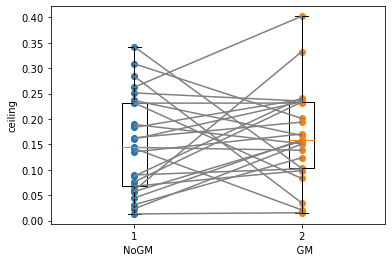

In [32]:
plt.boxplot([NoGM,GM])
plt.scatter([1]*len(NoGM),NoGM)
plt.scatter([2]*len(GM),GM)
plt.xlabel("NoGM                                              GM")
plt.ylabel("ceiling")
for a,b in zip(NoGM,GM):
    plt.plot([1,2],[a,b],c='grey')

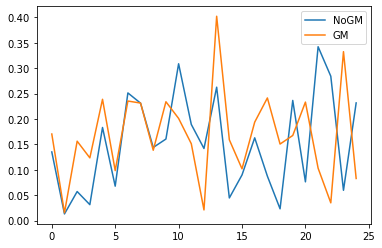

In [29]:
plt.plot(np.arange(len(NoGM)),NoGM,label="NoGM")
plt.plot(np.arange(len(GM)),GM,label="GM")
plt.legend()

In [23]:
from scipy import stats
rvs1 = NoGM
rvs2 = GM
stats.ttest_rel(rvs1,rvs2)


Ttest_relResult(statistic=-0.6496666912413098, pvalue=0.522077559301305)

In [33]:
stats.ttest_rel(np.arange(1,4),np.arange(2,5))

Ttest_relResult(statistic=-inf, pvalue=0.0)

In [35]:
GM_ceilings=[0.1704018019671017,
 0.015473825479978038,
 0.156277891292176,
 0.1234585334065389,
 0.23871839204563827,
 0.09837705349563342,
 0.23528731137622036,
 0.23130485589191493,
 0.13846164383941578,
 0.23388283785077046,
 0.20108707419544591,
 0.1512688639136599,
 0.02098889405777557,
 0.40217563355892294,
 0.15899675598518231,
 0.10188696143122584,
 0.19378255742049785,
 0.24137653795983605,
 0.15063441599697375,
 0.1675121356064939,
 0.2332026859351661,
 0.10311784816750072,
 0.03493032693679105,
 0.3324759723502478,
 0.08287185584068701]
ceilings={}
for i,sub in enumerate(subjects):
    ceilings[sub]=GM_ceilings[i]
ceilings

{'1206161': 0.1704018019671017,
 '0119173': 0.015473825479978038,
 '1206162': 0.156277891292176,
 '1130161': 0.1234585334065389,
 '1206163': 0.23871839204563827,
 '0120171': 0.09837705349563342,
 '0111171': 0.23528731137622036,
 '1202161': 0.23130485589191493,
 '0125172': 0.13846164383941578,
 '0110172': 0.23388283785077046,
 '0123173': 0.20108707419544591,
 '0120173': 0.1512688639136599,
 '0110171': 0.02098889405777557,
 '0119172': 0.40217563355892294,
 '0124171': 0.15899675598518231,
 '0123171': 0.10188696143122584,
 '1203161': 0.19378255742049785,
 '0118172': 0.24137653795983605,
 '0118171': 0.15063441599697375,
 '0112171': 0.1675121356064939,
 '1207162': 0.2332026859351661,
 '0117171': 0.10311784816750072,
 '0119174': 0.03493032693679105,
 '0112173': 0.3324759723502478,
 '0112172': 0.08287185584068701}

In [39]:

tag="GM"
subject="0112173"
testRun=6


from scipy.stats import zscore
def normalize(X):
    _X=X.copy()
    _X = zscore(_X, axis=0)
    _X[np.isnan(_X)]=0
    return _X
'''
purpose:
    get the morphing target function
steps:
    load train clf
    load brain data and behavior data
    get the morphing target function
        evidence_floor is C evidence for CD classifier(can also be D evidence for CD classifier)
        evidence_ceil  is A evidence in AC and AD classifier
'''

import os
import numpy as np
import pandas as pd
import joblib
import nibabel as nib


phasedict = dict(zip([1,2,3,4,5,6],["12", "12", "34", "34", "56", "56"]))
imcodeDict={"A": "bed", "B": "Chair", "C": "table", "D": "bench"}
if 'milgram' in os.getcwd():
    main_dir='/gpfs/milgram/project/turk-browne/projects/rtTest/'
else:
    main_dir='/Users/kailong/Desktop/rtTest'

working_dir=main_dir
os.chdir(working_dir)

funcdata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/{sub}_neurosketch/data/nifti/realtime_preprocessed/{sub}_neurosketch_recognition_run_{run}.nii.gz"
metadata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/data/features/recog/metadata_{sub}_V1_{phase}.csv"

metas = []

run=testRun
print(run, end='--')
# retrieve from the dictionary which phase it is, assign the session
phase = phasedict[run]
ses = 1

# Build the path for the preprocessed functional data
this4d = funcdata.format(ses=ses, run=run, phase=phase, sub=subject)

# Read in the metadata, and reduce it to only the TR values from this run, add to a list
thismeta = pd.read_csv(metadata.format(ses=ses, run=run, phase=phase, sub=subject))
if dataSource == "neurosketch":
    _run = 1 if run % 2 == 0 else 2
else:
    _run = run
thismeta = thismeta[thismeta['run_num'] == int(_run)]

if dataSource == "realtime":
    TR_num = list(thismeta.TR.astype(int))
    labels = list(thismeta.Item)
    labels = [imcodeDict[label] for label in labels]
else:
    TR_num = list(thismeta.TR_num.astype(int))
    labels = list(thismeta.label)

print("LENGTH OF TR: {}".format(len(TR_num)))
# Load the functional data
runIm = nib.load(this4d)
affine_mat = runIm.affine
runImDat = runIm.get_fdata()

# Use the TR numbers to select the correct features
features = [runImDat[:,:,:,n+3] for n in TR_num]
features = np.array(features)
chosenMask = np.load(f"/gpfs/milgram/project/turk-browne/projects/rtTest/schaefer2018/{subject}/chosenMask_{tag}.npy")
features = features[:, chosenMask==1]
print("shape of features", features.shape, "shape of chosenMask", chosenMask.shape)
# featmean = features.mean(1).mean(1).mean(1)[..., None,None,None] #features.mean(1)[..., None]
# features = features - featmean
# features = features - features.mean(0)
features = normalize(features)
# features = np.expand_dims(features, 0)

# Append both so we can use it later
# metas.append(labels)
# metas['label']

t=pd.DataFrame()
t['label']=labels
t["run_num"]=run
behav_data=t

runs = features


dimsize = runIm.header.get_zooms()

brain_data = runs
print(brain_data.shape)
print(behav_data.shape)
FEAT=brain_data
print(f"FEAT.shape={FEAT.shape}")
META=behav_data

# convert item colume to label colume
imcodeDict={
'A': 'bed',
'B': 'chair',
'C': 'table',
'D': 'bench'}


# def classifierEvidence(clf,X,Y):
#     ID=np.where((clf.classes_==Y)*1==1)[0][0]
#     Evidence=(X@clf.coef_.T+clf.intercept_) if ID==1 else (-(X@clf.coef_.T+clf.intercept_))
#     # Evidence=(X@clf.coef_.T+clf.intercept_) if ID==0 else (-(X@clf.coef_.T+clf.intercept_))
#     return np.asarray(Evidence)

# def classifierEvidence(clf,X,Y):
#     ID=np.where((clf.classes_==Y)*1==1)[0][0]
#     p = clf.predict_proba(X)[:,ID]
#     BX=np.log(p/(1-p))
#     return BX

def classifierProb(clf,X,Y):
    ID=np.where((clf.classes_==Y)*1==1)[0][0]
    p = clf.predict_proba(X)[:,ID]
    return p

6--LENGTH OF TR: 80
shape of features (80, 6796) shape of chosenMask (94, 94, 72)
(80, 6796)
(80, 2)
FEAT.shape=(80, 6796)


In [41]:
A_ID = (META['label']=='bed')
X_A = FEAT[A_ID]

B_ID = (META['label']=='chair')
X_B = FEAT[B_ID]

C_ID = (META['label']=='table')
X_C = FEAT[C_ID]

D_ID = (META['label']=='bench')
X_D = FEAT[D_ID]


model_folder = f"{working_dir}{roiloc}/{subject}/clf/"
ceilings={'1206161': 0.1704018019671017,
'0119173': 0.015473825479978038,
'1206162': 0.156277891292176,
'1130161': 0.1234585334065389,
'1206163': 0.23871839204563827,
'0120171': 0.09837705349563342,
'0111171': 0.23528731137622036,
'1202161': 0.23130485589191493,
'0125172': 0.13846164383941578,
'0110172': 0.23388283785077046,
'0123173': 0.20108707419544591,
'0120173': 0.1512688639136599,
'0110171': 0.02098889405777557,
'0119172': 0.40217563355892294,
'0124171': 0.15899675598518231,
'0123171': 0.10188696143122584,
'1203161': 0.19378255742049785,
'0118172': 0.24137653795983605,
'0118171': 0.15063441599697375,
'0112171': 0.1675121356064939,
'1207162': 0.2332026859351661,
'0117171': 0.10311784816750072,
'0119174': 0.03493032693679105,
'0112173': 0.3324759723502478,
'0112172': 0.08287185584068701}
ceil=ceilings[subject]
floor=0
mu = (ceil+floor)/2
sig = (ceil-floor)/2.3548
print(f"floor={floor}, ceil={ceil}")
print(f"mu={mu}, sig={sig}")


BC_clf=joblib.load(model_folder +'benchchair_chairtable.joblib') # These 4 clf are the same: bedbench_benchtable.joblib bedtable_tablebench.joblib benchchair_benchtable.joblib chairtable_tablebench.joblib
BD_clf=joblib.load(model_folder +'bedchair_chairbench.joblib') # These 4 clf are the same: bedbench_benchtable.joblib bedtable_tablebench.joblib benchchair_benchtable.joblib chairtable_tablebench.joblib


floor=0, ceil=0.3324759723502478
mu=0.1662379861751239, sig=0.14119074755828426


In [49]:
def classifierEvidence(clf,X,Y):
    ID=np.where((clf.classes_==Y)*1==1)[0][0]
    p = clf.predict_proba(X)[:,ID]
    BX=np.log(p/(1-p))
    return BX
def gaussian(x, mu, sig):
    # mu and sig is determined before each neurofeedback session using 2 recognition runs.
    return np.round(1+18*(1 - np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.))))) # map from (-∞,∞) -> [1,19]

def BEvi(X):
    # print(f"classifierEvidence(BC_clf,X,Y)={classifierEvidence(BC_clf,X,Y)}")
    # print(f"classifierEvidence(BD_clf,X,Y)={classifierEvidence(BD_clf,X,Y)}")
    BC_B_evidence = classifierEvidence(BC_clf,X,'chair')
    BD_B_evidence = classifierEvidence(BD_clf,X,'chair')
    # print(f"BC_B_evidence={BC_B_evidence}")
    # print(f"BD_B_evidence={BD_B_evidence}")
    B_evidence = (BC_B_evidence+BD_B_evidence)/2
    morphParam=gaussian(B_evidence, mu, sig)
    return B_evidence , morphParam
BEvi(X_A)

(array([-0.20028687, -1.85598393,  1.09905423,  0.55542611,  1.90848297,
         1.10168752,  0.43749775,  0.89077132,  1.46928696, -0.70925405,
        -2.34614487, -1.52697044, -0.51170879,  0.03843049, -0.50596496,
         0.33987598, -0.61830017, -0.23815065, -2.56796176,  0.90657342]),
 array([18., 19., 19., 19., 19., 19., 16., 19., 19., 19., 19., 19., 19.,
         7., 19., 11., 19., 19., 19., 19.]))

Text(0.5, 1.0, 'morphParams')

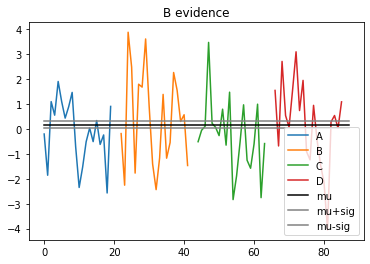

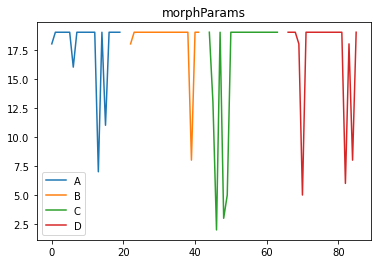

In [62]:
B_evidences , morphParams=[],[]
for X in [X_A,X_B,X_C,X_D]:
    B_evidence , morphParam = BEvi(X)
    B_evidences.append(B_evidence) 
    morphParams.append(morphParam)

start=0
for i,label in enumerate(["A","B","C","D"]):
    plt.plot(np.arange(start,start+len(B_evidences[i])) , B_evidences[i],label=label)
    start=start+len(B_evidences[i])+2
plt.plot(np.arange(0,start),len(np.arange(0,start))*[mu],label="mu",c="black")
plt.plot(np.arange(0,start),len(np.arange(0,start))*[mu+sig],label="mu+sig",c="grey")
plt.plot(np.arange(0,start),len(np.arange(0,start))*[mu-sig],label="mu-sig",c="grey")
plt.legend()
plt.title("B evidence")

plt.figure()
start=0
for i,label in enumerate(["A","B","C","D"]):
    plt.plot(np.arange(start,start+len(morphParams[i])) , morphParams[i],label=label)
    start=start+len(morphParams[i])+2
plt.legend()
plt.title("morphParams")


6--LENGTH OF TR: 80
shape of features (80, 8204) shape of chosenMask (94, 94, 72)
(80, 8204)
(80, 2)
FEAT.shape=(80, 8204)
floor=0, ceil=0.1704018019671017
mu=0.08520090098355085, sig=0.07236359859312964
6--LENGTH OF TR: 80
shape of features (80, 7209) shape of chosenMask (94, 94, 72)
(80, 7209)
(80, 2)
FEAT.shape=(80, 7209)
floor=0, ceil=0.015473825479978038
mu=0.007736912739989019, sig=0.006571184593162068
6--LENGTH OF TR: 80
shape of features (80, 8554) shape of chosenMask (94, 94, 72)
(80, 8554)
(80, 2)
FEAT.shape=(80, 8554)
floor=0, ceil=0.156277891292176
mu=0.078138945646088, sig=0.06636567491599117
6--LENGTH OF TR: 80
shape of features (80, 5739) shape of chosenMask (94, 94, 72)
(80, 5739)
(80, 2)
FEAT.shape=(80, 5739)
floor=0, ceil=0.1234585334065389
mu=0.06172926670326945, sig=0.05242845821578856
6--LENGTH OF TR: 80
shape of features (80, 4591) shape of chosenMask (94, 94, 72)
(80, 4591)
(80, 2)
FEAT.shape=(80, 4591)
floor=0, ceil=0.23871839204563827
mu=0.11935919602281914, si

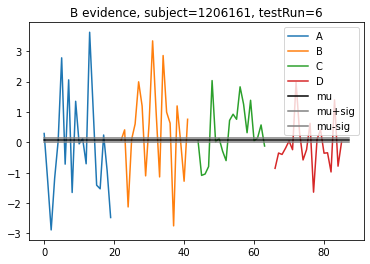

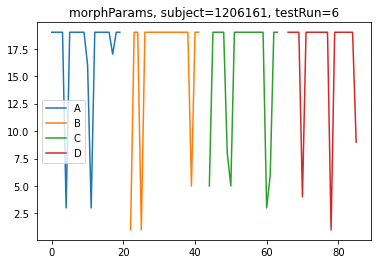

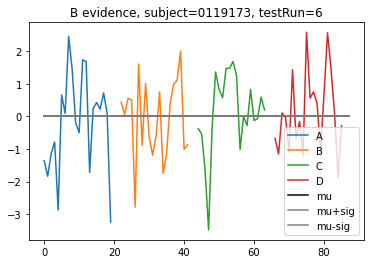

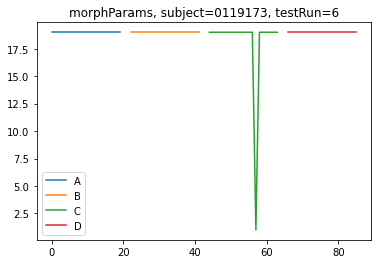

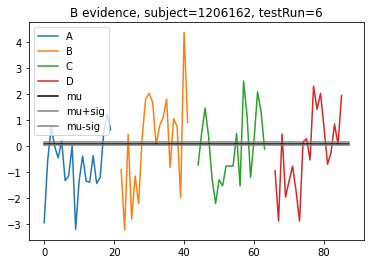

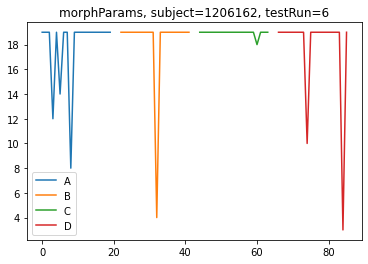

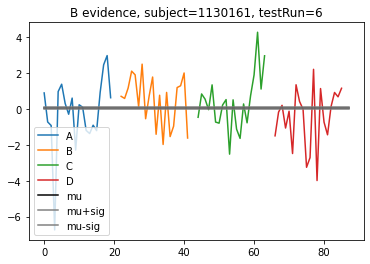

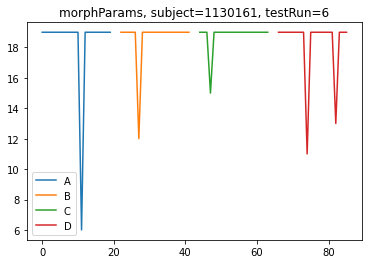

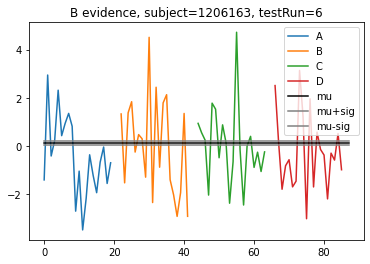

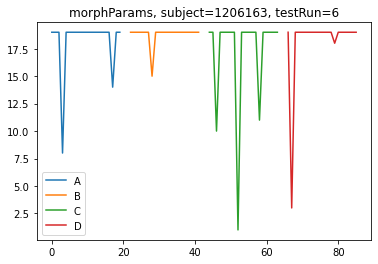

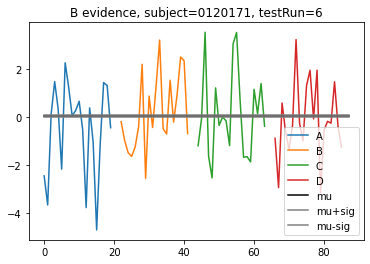

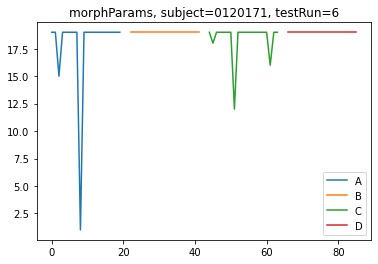

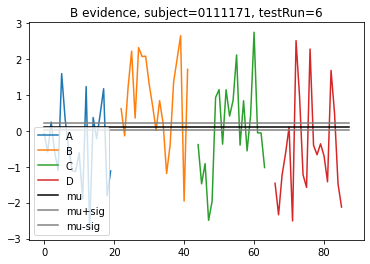

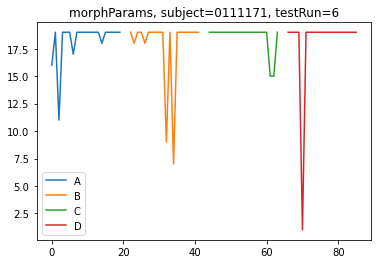

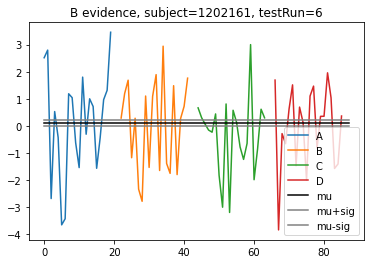

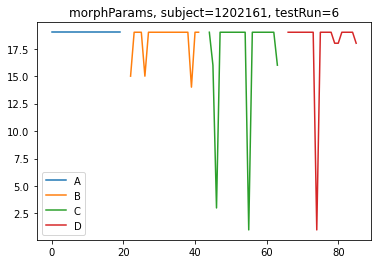

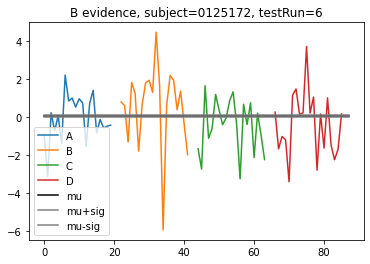

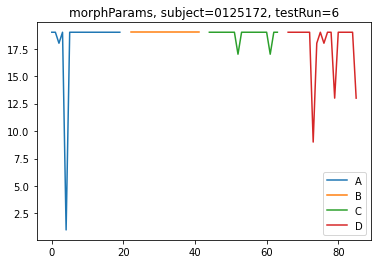

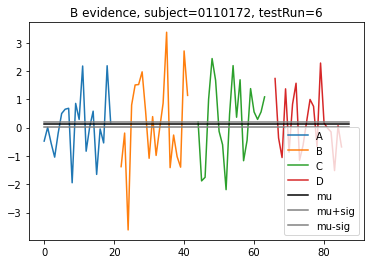

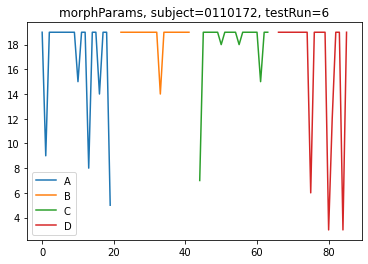

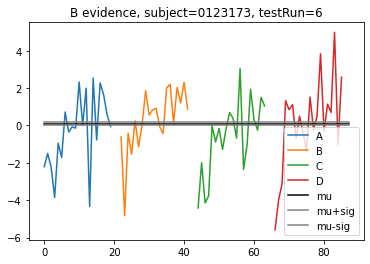

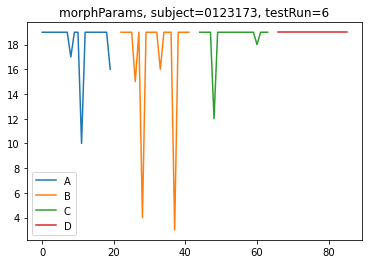

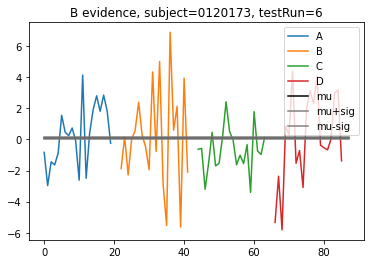

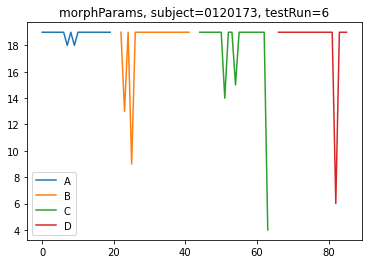

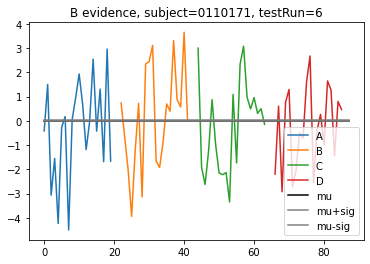

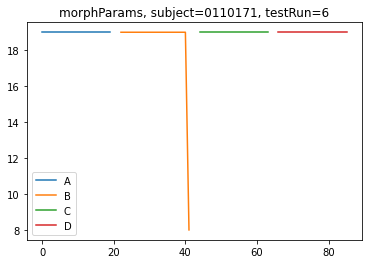

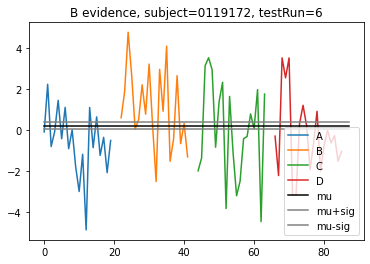

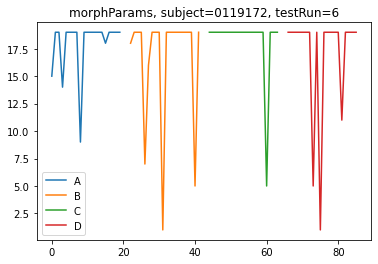

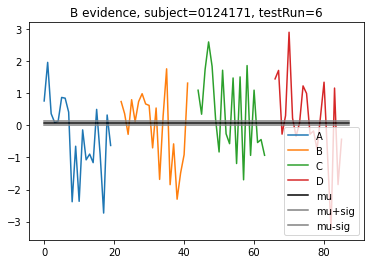

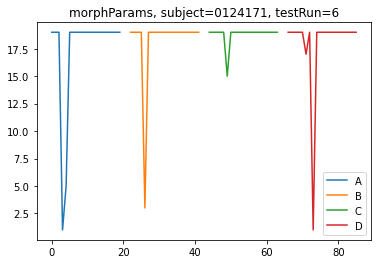

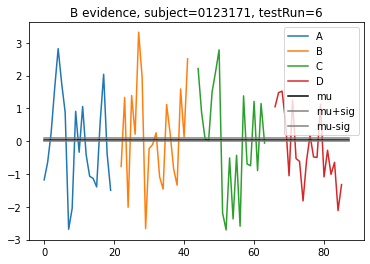

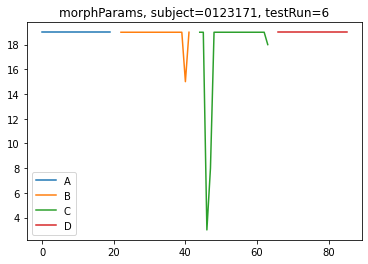

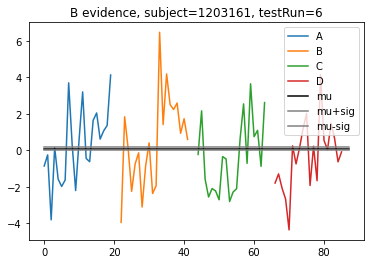

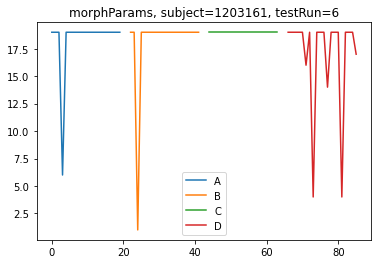

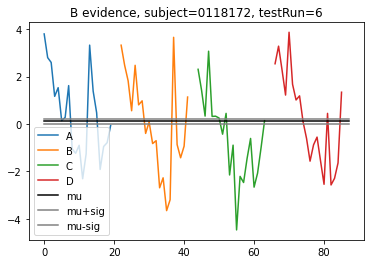

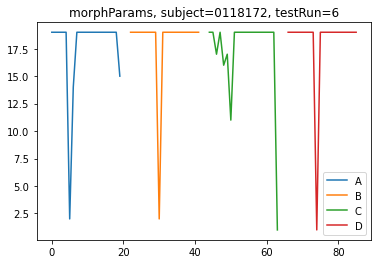

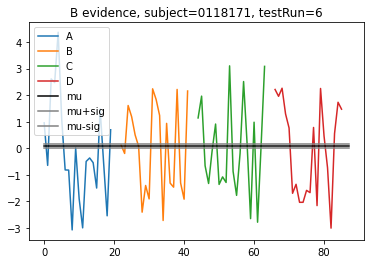

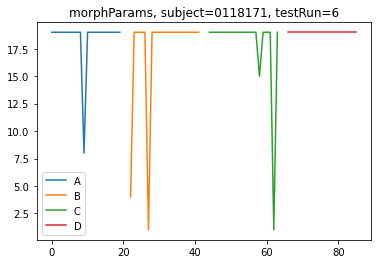

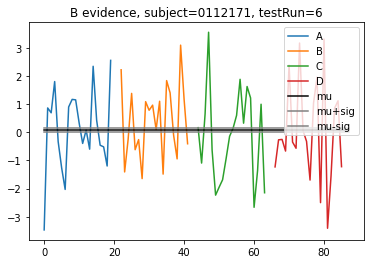

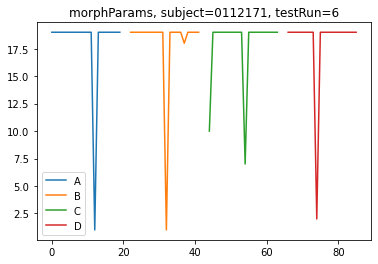

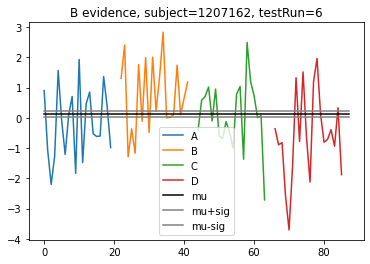

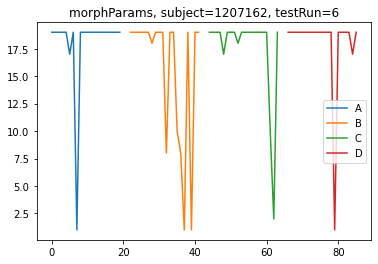

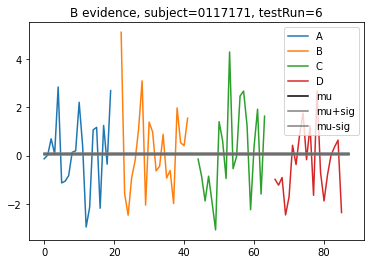

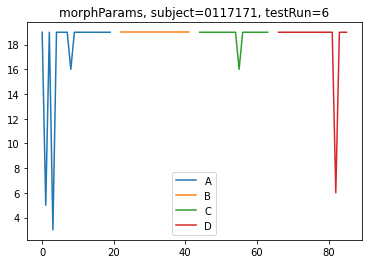

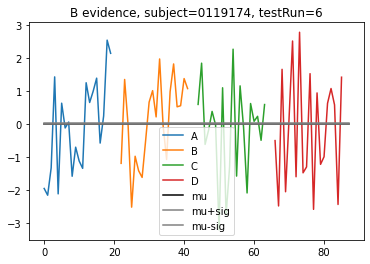

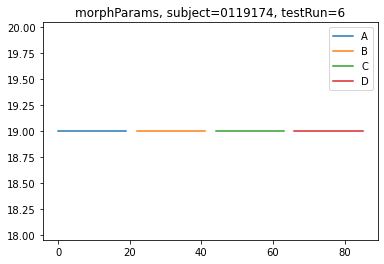

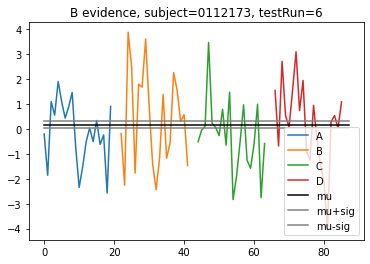

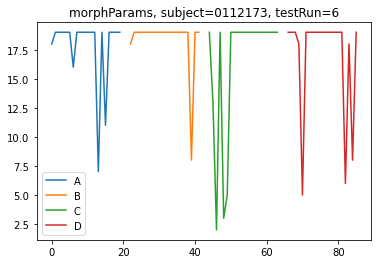

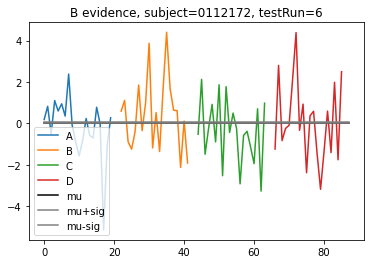

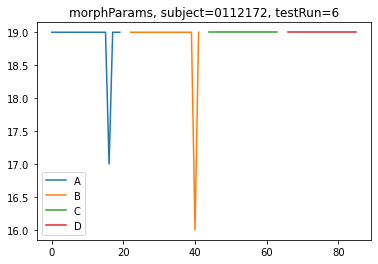

In [69]:
'''
calculate the evidence floor and ceil for each subject and display different forms of evidences.
'''
def morphingTarget(subject,testRun=6):
    '''
    purpose:
        get the morphing target function
    steps:
        load train clf
        load brain data and behavior data
        get the morphing target function
            evidence_floor is C evidence for CD classifier(can also be D evidence for CD classifier)
            evidence_ceil  is A evidence in AC and AD classifier
    '''

    import os
    import numpy as np
    import pandas as pd
    import joblib
    import nibabel as nib


    phasedict = dict(zip([1,2,3,4,5,6],["12", "12", "34", "34", "56", "56"]))
    imcodeDict={"A": "bed", "B": "Chair", "C": "table", "D": "bench"}
    if 'milgram' in os.getcwd():
        main_dir='/gpfs/milgram/project/turk-browne/projects/rtTest/'
    else:
        main_dir='/Users/kailong/Desktop/rtTest'

    working_dir=main_dir
    os.chdir(working_dir)

    funcdata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/{sub}_neurosketch/data/nifti/realtime_preprocessed/{sub}_neurosketch_recognition_run_{run}.nii.gz"
    metadata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/data/features/recog/metadata_{sub}_V1_{phase}.csv"

    metas = []

    run=testRun
    print(run, end='--')
    # retrieve from the dictionary which phase it is, assign the session
    phase = phasedict[run]
    ses = 1
    
    # Build the path for the preprocessed functional data
    this4d = funcdata.format(ses=ses, run=run, phase=phase, sub=subject)
    
    # Read in the metadata, and reduce it to only the TR values from this run, add to a list
    thismeta = pd.read_csv(metadata.format(ses=ses, run=run, phase=phase, sub=subject))
    if dataSource == "neurosketch":
        _run = 1 if run % 2 == 0 else 2
    else:
        _run = run
    thismeta = thismeta[thismeta['run_num'] == int(_run)]
    
    if dataSource == "realtime":
        TR_num = list(thismeta.TR.astype(int))
        labels = list(thismeta.Item)
        labels = [imcodeDict[label] for label in labels]
    else:
        TR_num = list(thismeta.TR_num.astype(int))
        labels = list(thismeta.label)
    
    print("LENGTH OF TR: {}".format(len(TR_num)))
    # Load the functional data
    runIm = nib.load(this4d)
    affine_mat = runIm.affine
    runImDat = runIm.get_fdata()
    
    # Use the TR numbers to select the correct features
    features = [runImDat[:,:,:,n+3] for n in TR_num]
    features = np.array(features)
    chosenMask = np.load(f"/gpfs/milgram/project/turk-browne/projects/rtTest/schaefer2018/{subject}/chosenMask_{tag}.npy")
    features = features[:, chosenMask==1]
    print("shape of features", features.shape, "shape of chosenMask", chosenMask.shape)
    # featmean = features.mean(1).mean(1).mean(1)[..., None,None,None] #features.mean(1)[..., None]
    # features = features - featmean
    # features = features - features.mean(0)
    features = normalize(features)
    # features = np.expand_dims(features, 0)
    
    # Append both so we can use it later
    # metas.append(labels)
    # metas['label']

    t=pd.DataFrame()
    t['label']=labels
    t["run_num"]=run
    behav_data=t
    
    runs = features

    
    dimsize = runIm.header.get_zooms()
    
    brain_data = runs
    print(brain_data.shape)
    print(behav_data.shape)
    FEAT=brain_data
    print(f"FEAT.shape={FEAT.shape}")
    META=behav_data

    # convert item colume to label colume
    imcodeDict={
    'A': 'bed',
    'B': 'chair',
    'C': 'table',
    'D': 'bench'}


    # def classifierEvidence(clf,X,Y):
    #     ID=np.where((clf.classes_==Y)*1==1)[0][0]
    #     Evidence=(X@clf.coef_.T+clf.intercept_) if ID==1 else (-(X@clf.coef_.T+clf.intercept_))
    #     # Evidence=(X@clf.coef_.T+clf.intercept_) if ID==0 else (-(X@clf.coef_.T+clf.intercept_))
    #     return np.asarray(Evidence)

    def classifierEvidence(clf,X,Y):
        ID=np.where((clf.classes_==Y)*1==1)[0][0]
        p = clf.predict_proba(X)[:,ID]
        BX=np.log(p/(1-p))
        return BX

    def classifierProb(clf,X,Y):
        ID=np.where((clf.classes_==Y)*1==1)[0][0]
        p = clf.predict_proba(X)[:,ID]
        return p
    # imcodeDict={
    # 'A': 'bed',
    # 'B': 'chair',
    # 'C': 'table',
    # 'D': 'bench'}
    A_ID = (META['label']=='bed')
    X_A = FEAT[A_ID]

    B_ID = (META['label']=='chair')
    X_B = FEAT[B_ID]

    C_ID = (META['label']=='table')
    X_C = FEAT[C_ID]

    D_ID = (META['label']=='bench')
    X_D = FEAT[D_ID]


    model_folder = f"{working_dir}{roiloc}/{subject}/clf/"
    ceilings={'1206161': 0.1704018019671017,
    '0119173': 0.015473825479978038,
    '1206162': 0.156277891292176,
    '1130161': 0.1234585334065389,
    '1206163': 0.23871839204563827,
    '0120171': 0.09837705349563342,
    '0111171': 0.23528731137622036,
    '1202161': 0.23130485589191493,
    '0125172': 0.13846164383941578,
    '0110172': 0.23388283785077046,
    '0123173': 0.20108707419544591,
    '0120173': 0.1512688639136599,
    '0110171': 0.02098889405777557,
    '0119172': 0.40217563355892294,
    '0124171': 0.15899675598518231,
    '0123171': 0.10188696143122584,
    '1203161': 0.19378255742049785,
    '0118172': 0.24137653795983605,
    '0118171': 0.15063441599697375,
    '0112171': 0.1675121356064939,
    '1207162': 0.2332026859351661,
    '0117171': 0.10311784816750072,
    '0119174': 0.03493032693679105,
    '0112173': 0.3324759723502478,
    '0112172': 0.08287185584068701}
    ceil=ceilings[subject]
    floor=0
    mu = (ceil+floor)/2
    sig = (ceil-floor)/2.3548
    print(f"floor={floor}, ceil={ceil}")
    print(f"mu={mu}, sig={sig}")


    BC_clf=joblib.load(model_folder +'benchchair_chairtable.joblib') # These 4 clf are the same: bedbench_benchtable.joblib bedtable_tablebench.joblib benchchair_benchtable.joblib chairtable_tablebench.joblib
    BD_clf=joblib.load(model_folder +'bedchair_chairbench.joblib') # These 4 clf are the same: bedbench_benchtable.joblib bedtable_tablebench.joblib benchchair_benchtable.joblib chairtable_tablebench.joblib
    def gaussian(x, mu, sig):
        # mu and sig is determined before each neurofeedback session using 2 recognition runs.
        return np.round(1+18*(1 - np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.))))) # map from (-∞,∞) -> [1,19]

    def BEvi(X):
        # print(f"classifierEvidence(BC_clf,X,Y)={classifierEvidence(BC_clf,X,Y)}")
        # print(f"classifierEvidence(BD_clf,X,Y)={classifierEvidence(BD_clf,X,Y)}")
        BC_B_evidence = classifierEvidence(BC_clf,X,'chair')
        BD_B_evidence = classifierEvidence(BD_clf,X,'chair')
        # print(f"BC_B_evidence={BC_B_evidence}")
        # print(f"BD_B_evidence={BD_B_evidence}")
        B_evidence = (BC_B_evidence+BD_B_evidence)/2
        morphParam=gaussian(B_evidence, mu, sig)
        return B_evidence , morphParam
            
    B_evidences , morphParams=[],[]
    for X in [X_A,X_B,X_C,X_D]:
        B_evidence , morphParam = BEvi(X)
        B_evidences.append(B_evidence) 
        morphParams.append(morphParam)

    plt.figure()
    start=0
    for i,label in enumerate(["A","B","C","D"]):
        plt.plot(np.arange(start,start+len(B_evidences[i])) , B_evidences[i],label=label)
        start=start+len(B_evidences[i])+2
    plt.plot(np.arange(0,start),len(np.arange(0,start))*[mu],label="mu",c="black")
    plt.plot(np.arange(0,start),len(np.arange(0,start))*[mu+sig],label="mu+sig",c="grey")
    plt.plot(np.arange(0,start),len(np.arange(0,start))*[mu-sig],label="mu-sig",c="grey")
    plt.legend()
    plt.title(f"B evidence, subject={subject}, testRun={testRun}")

    plt.figure()
    start=0
    for i,label in enumerate(["A","B","C","D"]):
        plt.plot(np.arange(start,start+len(morphParams[i])) , morphParams[i],label=label)
        start=start+len(morphParams[i])+2
    plt.legend()
    plt.title(f"morphParams, subject={subject}, testRun={testRun}")


    # store="\n"
    # print("floor")
    # # D evidence for AD_clf when A is presented.
    # Y = 'bench'
    # AD_clf=joblib.load(model_folder +'bedchair_bedbench.joblib') # These 4 clf are the same:   bedchair_bedbench.joblib bedtable_bedbench.joblib benchchair_benchbed.joblib benchtable_benchbed.joblib
    # AD_D_evidence = classifierProb(AD_clf,X,Y)
    # evidence_floor = np.mean(AD_D_evidence)
    # print(f"D evidence for AD_clf when A is presented={evidence_floor}")
    # store=store+f"D evidence for AD_clf when A is presented={evidence_floor}"

    # # C evidence for AC_clf when A is presented.
    # Y = 'table'
    # AC_clf=joblib.load(model_folder +'benchtable_tablebed.joblib') # These 4 clf are the same:   bedbench_bedtable.joblib bedchair_bedtable.joblib benchtable_tablebed.joblib chairtable_tablebed.joblib
    # AC_C_evidence = classifierProb(AC_clf,X,Y)
    # evidence_floor = np.mean(AC_C_evidence)
    # print(f"C evidence for AC_clf when A is presented={evidence_floor}")
    # store=store+"\n"+f"C evidence for AC_clf when A is presented={evidence_floor}"

    # # D evidence for CD_clf when A is presented.
    # Y = 'bench'
    # CD_clf=joblib.load(model_folder +'bedbench_benchtable.joblib') # These 4 clf are the same: bedbench_benchtable.joblib bedtable_tablebench.joblib benchchair_benchtable.joblib chairtable_tablebench.joblib
    # CD_D_evidence = classifierProb(CD_clf,X,Y)
    # evidence_floor1 = np.mean(CD_D_evidence)
    # print(f"D evidence for CD_clf when A is presented={evidence_floor1}")
    # store=store+"\n"+f"D evidence for CD_clf when A is presented={evidence_floor1}"

    # # C evidence for CD_clf when A is presented.
    # Y = 'table'
    # CD_clf=joblib.load(model_folder +'bedbench_benchtable.joblib') # These 4 clf are the same: bedbench_benchtable.joblib bedtable_tablebench.joblib benchchair_benchtable.joblib chairtable_tablebench.joblib
    # CD_C_evidence = classifierProb(CD_clf,X,Y)
    # evidence_floor2 = np.mean(CD_C_evidence)
    # print(f"C evidence for CD_clf when A is presented={evidence_floor2}")
    # store=store+"\n"+f"C evidence for CD_clf when A is presented={evidence_floor2}"

    # # set floor to be 0, (aka before inverting is 0.5) and only estimate ceiling # edited 03152021
    # evidence_floor = 0.5 #max(evidence_floor1,evidence_floor2)
    # store=store+f"\nmax(evidence_floor1,evidence_floor2)={evidence_floor} unique_Mark"


    # print("ceil")
    # store=store+"\n"+"ceil"
    # # evidence_ceil  is A evidence in AC and AD classifier
    # Y = 'bed'
    # AC_clf=joblib.load(model_folder +'benchtable_tablebed.joblib') # These 4 clf are the same:   bedbench_bedtable.joblib bedchair_bedtable.joblib benchtable_tablebed.joblib chairtable_tablebed.joblib
    # AC_A_evidence = classifierProb(AC_clf,X,Y)
    # evidence_ceil1 = AC_A_evidence
    # print(f"A evidence in AC_clf when A is presented={np.mean(evidence_ceil1)}")
    # store=store+"\n"+f"A evidence in AC_clf when A is presented={np.mean(evidence_ceil1)}"

    # Y = 'bed'
    # AD_clf=joblib.load(model_folder +'bedchair_bedbench.joblib') # These 4 clf are the same:   bedchair_bedbench.joblib bedtable_bedbench.joblib benchchair_benchbed.joblib benchtable_benchbed.joblib
    # AD_A_evidence = classifierProb(AD_clf,X,Y)
    # evidence_ceil2 = AD_A_evidence
    # print(f"A evidence in AD_clf when A is presented={np.mean(evidence_ceil2)}")
    # store=store+"\n"+f"A evidence in AD_clf when A is presented={np.mean(evidence_ceil2)}"

    # # evidence_ceil = np.mean(evidence_ceil1)
    # # evidence_ceil = np.mean(evidence_ceil2)
    # evidence_ceil = np.mean((evidence_ceil1+evidence_ceil2)/2)
    # print(f"evidence_ceil={evidence_ceil} uniqueMark")
    # store=store+f"\nevidence_ceil={evidence_ceil} uniqueMark"

    # ceil,floor=logit(evidence_ceil),logit(evidence_floor)
    # mu = (ceil+floor)/2
    # sig = (ceil-floor)/2.3548
    # print(f"floor={floor}, ceil={ceil}")
    # print(f"mu={mu}, sig={sig}")

    # store=store+"\n"+f"floor={floor}, ceil={ceil}"
    # store=store+"\n"+f"mu={mu}, sig={sig}"


    # BC_clf=joblib.load(model_folder +'benchchair_chairtable.joblib') # These 4 clf are the same: bedbench_benchtable.joblib bedtable_tablebench.joblib benchchair_benchtable.joblib chairtable_tablebench.joblib
    # BD_clf=joblib.load(model_folder +'bedchair_chairbench.joblib') # These 4 clf are the same: bedbench_benchtable.joblib bedtable_tablebench.joblib benchchair_benchtable.joblib chairtable_tablebench.joblib
    # Y = 'chair'
    # # imcodeDict={
    # # 'A': 'bed',
    # # 'B': 'chair',
    # # 'C': 'table',
    # # 'D': 'bench'}
    # print(f"classifierProb(BC_clf,FEAT,Y)={classifierProb(BC_clf,FEAT,Y)}")
    # print(f"classifierProb(BD_clf,FEAT,Y)={classifierProb(BD_clf,FEAT,Y)}")


    # # # convert item colume to label colume
    # # imcodeDict={
    # # 'A': 'bed',
    # # 'B': 'chair',
    # # 'C': 'table',
    # # 'D': 'bench'}
    # def testMorphParamFor(A): #A='bed''chair'...
    #     A_ID = (META['label']==A)
    #     X = FEAT[A_ID]


    #     # 这里的X是选择的testRun里面的所有的展示A的trials
    #     BC_B_evidence = classifierProb(BC_clf,X,Y)
    #     BD_B_evidence = classifierProb(BD_clf,X,Y)
    #     print(f"BC_B_evidence={BC_B_evidence}")
    #     print(f"BD_B_evidence={BD_B_evidence}")
    #     B_evidence = (BC_B_evidence+BD_B_evidence)/2
    #     print(f"B_evidence={B_evidence}")
    #     print(f"mu={mu}, sig={sig}")
        



    #     morphParam=np.mean(gaussian(B_evidence, mu, sig))
    #     # B_evidences.append(B_evidence)
    #     print(f"morphParam={morphParam}")
    #     return f"morphParam for {A} = {morphParam}"

    # store=store+"\n"+testMorphParamFor('bed')
    # store=store+"\n"+testMorphParamFor('chair')
    # store=store+"\n"+testMorphParamFor('table')
    # store=store+"\n"+testMorphParamFor('bench')

    return B_evidences,morphParams
Evidence={}
for sub in subjects:
    Evidence[sub] = morphingTarget(sub)


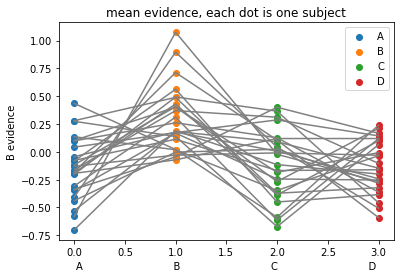

In [87]:
mean_evidence=np.zeros((len(subjects),4))
# sub="1206161"
# ii=0
for ii,sub in enumerate(subjects):
    mean_evidence[ii]=[np.mean(evidence) for evidence in Evidence[sub][0]]
mean_evidence
for i,label in enumerate(["A","B","C","D"]):
    plt.scatter([i]*(len(subjects)),mean_evidence[:,i],label=label)

plt.legend()
plt.title("mean evidence, each dot is one subject")
plt.xlabel("A                             B                             C                             D")                 
plt.ylabel("B evidence")

for ii,sub in enumerate(subjects):
    plt.plot([0,1,2,3],mean_evidence[ii],c="grey")

In [100]:
def RTnormalize(features):
    raw = np.expand_dims(features[0], 0)
    acc_norm_data=raw
    for curr_TR in range(1,features.shape[0]):
        raw = np.concatenate((raw,np.expand_dims(features[curr_TR],0)),axis=0)
        raw_normalized=raw.copy()
        raw_normalized=normalize(raw_normalized)
        acc_norm_data = np.concatenate((acc_norm_data,np.expand_dims(raw_normalized[-1],0)),axis=0)
        print(acc_norm_data.shape)
    return acc_norm_data

(2, 6796)
(3, 6796)
(4, 6796)
(5, 6796)
(6, 6796)
(7, 6796)
(8, 6796)
(9, 6796)
(10, 6796)
(11, 6796)
(12, 6796)
(13, 6796)
(14, 6796)
(15, 6796)
(16, 6796)
(17, 6796)
(18, 6796)
(19, 6796)
(20, 6796)
(21, 6796)
(22, 6796)
(23, 6796)
(24, 6796)
(25, 6796)
(26, 6796)
(27, 6796)
(28, 6796)
(29, 6796)
(30, 6796)
(31, 6796)
(32, 6796)
(33, 6796)
(34, 6796)
(35, 6796)
(36, 6796)
(37, 6796)
(38, 6796)
(39, 6796)
(40, 6796)
(41, 6796)
(42, 6796)
(43, 6796)
(44, 6796)
(45, 6796)
(46, 6796)
(47, 6796)
(48, 6796)
(49, 6796)
(50, 6796)
(51, 6796)
(52, 6796)
(53, 6796)
(54, 6796)
(55, 6796)
(56, 6796)
(57, 6796)
(58, 6796)
(59, 6796)
(60, 6796)
(61, 6796)
(62, 6796)
(63, 6796)
(64, 6796)
(65, 6796)
(66, 6796)
(67, 6796)
(68, 6796)
(69, 6796)
(70, 6796)
(71, 6796)
(72, 6796)
(73, 6796)
(74, 6796)
(75, 6796)
(76, 6796)
(77, 6796)
(78, 6796)
(79, 6796)
(80, 6796)


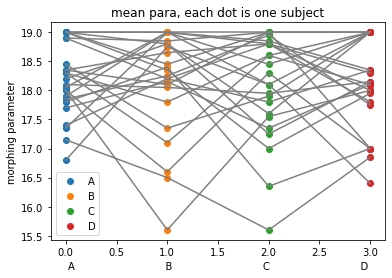

In [90]:
mean_para=np.zeros((len(subjects),4))
# sub="1206161"
# ii=0
for ii,sub in enumerate(subjects):
    mean_para[ii]=[np.mean(para) for para in Evidence[sub][1]]
mean_para
for i,label in enumerate(["A","B","C","D"]):
    plt.scatter([i]*(len(subjects)),mean_para[:,i],label=label)

plt.legend()
plt.title("mean para, each dot is one subject")
plt.xlabel("A                             B                             C                             D")                 
plt.ylabel("morphing parameter")

for ii,sub in enumerate(subjects):
    plt.plot([0,1,2,3],mean_para[ii],c="grey")

conda env=/gpfs/milgram/project/turk-browne/users/kp578/CONDA/rtcloud
di['bestROIs']=('GM_19.nii.gz', 'GM_225.nii.gz', 'GM_86.nii.gz', 'GM_159.nii.gz', 'GM_65.nii.gz', 'GM_235.nii.gz', 'GM_108.nii.gz', 'GM_76.nii.gz', 'GM_166.nii.gz', 'GM_271.nii.gz', 'GM_164.nii.gz', 'GM_80.nii.gz', 'GM_89.nii.gz', 'GM_21.nii.gz', 'GM_126.nii.gz', 'GM_58.nii.gz', 'GM_93.nii.gz', 'GM_67.nii.gz', 'GM_209.nii.gz', 'GM_230.nii.gz', 'GM_265.nii.gz', 'GM_220.nii.gz', 'GM_263.nii.gz', 'GM_246.nii.gz', 'GM_243.nii.gz')
di['bestROIs']=('GM_234.nii.gz', 'GM_19.nii.gz', 'GM_86.nii.gz', 'GM_240.nii.gz', 'GM_114.nii.gz', 'GM_65.nii.gz', 'GM_284.nii.gz', 'GM_139.nii.gz', 'GM_295.nii.gz', 'GM_258.nii.gz', 'GM_80.nii.gz', 'GM_89.nii.gz', 'GM_41.nii.gz', 'GM_132.nii.gz', 'GM_249.nii.gz', 'GM_49.nii.gz', 'GM_190.nii.gz', 'GM_93.nii.gz', 'GM_67.nii.gz', 'GM_265.nii.gz', 'GM_52.nii.gz', 'GM_146.nii.gz', 'GM_238.nii.gz', 'GM_263.nii.gz', 'GM_150.nii.gz', 'GM_281.nii.gz', 'GM_244.nii.gz', 'GM_30.nii.gz', 'GM_79.nii.gz')
di

6--LENGTH OF TR: 80
shape of features (80, 8204) shape of chosenMask (94, 94, 72)
(2, 8204)
(3, 8204)
(4, 8204)
(5, 8204)
(6, 8204)
(7, 8204)
(8, 8204)
(9, 8204)
(10, 8204)
(11, 8204)
(12, 8204)
(13, 8204)
(14, 8204)
(15, 8204)
(16, 8204)
(17, 8204)
(18, 8204)
(19, 8204)
(20, 8204)
(21, 8204)
(22, 8204)
(23, 8204)
(24, 8204)
(25, 8204)
(26, 8204)
(27, 8204)
(28, 8204)
(29, 8204)
(30, 8204)
(31, 8204)
(32, 8204)
(33, 8204)
(34, 8204)
(35, 8204)
(36, 8204)
(37, 8204)
(38, 8204)
(39, 8204)
(40, 8204)
(41, 8204)
(42, 8204)
(43, 8204)
(44, 8204)
(45, 8204)
(46, 8204)
(47, 8204)
(48, 8204)
(49, 8204)
(50, 8204)
(51, 8204)
(52, 8204)
(53, 8204)
(54, 8204)
(55, 8204)
(56, 8204)
(57, 8204)
(58, 8204)
(59, 8204)
(60, 8204)
(61, 8204)
(62, 8204)
(63, 8204)
(64, 8204)
(65, 8204)
(66, 8204)
(67, 8204)
(68, 8204)
(69, 8204)
(70, 8204)
(71, 8204)
(72, 8204)
(73, 8204)
(74, 8204)
(75, 8204)
(76, 8204)
(77, 8204)
(78, 8204)
(79, 8204)
(80, 8204)
(80, 8204)
(80, 2)
FEAT.shape=(80, 8204)
floor=0, ceil=0.

6--LENGTH OF TR: 80
shape of features (80, 7854) shape of chosenMask (94, 94, 72)
(2, 7854)
(3, 7854)
(4, 7854)
(5, 7854)
(6, 7854)
(7, 7854)
(8, 7854)
(9, 7854)
(10, 7854)
(11, 7854)
(12, 7854)
(13, 7854)
(14, 7854)
(15, 7854)
(16, 7854)
(17, 7854)
(18, 7854)
(19, 7854)
(20, 7854)
(21, 7854)
(22, 7854)
(23, 7854)
(24, 7854)
(25, 7854)
(26, 7854)
(27, 7854)
(28, 7854)
(29, 7854)
(30, 7854)
(31, 7854)
(32, 7854)
(33, 7854)
(34, 7854)
(35, 7854)
(36, 7854)
(37, 7854)
(38, 7854)
(39, 7854)
(40, 7854)
(41, 7854)
(42, 7854)
(43, 7854)
(44, 7854)
(45, 7854)
(46, 7854)
(47, 7854)
(48, 7854)
(49, 7854)
(50, 7854)
(51, 7854)
(52, 7854)
(53, 7854)
(54, 7854)
(55, 7854)
(56, 7854)
(57, 7854)
(58, 7854)
(59, 7854)
(60, 7854)
(61, 7854)
(62, 7854)
(63, 7854)
(64, 7854)
(65, 7854)
(66, 7854)
(67, 7854)
(68, 7854)
(69, 7854)
(70, 7854)
(71, 7854)
(72, 7854)
(73, 7854)
(74, 7854)
(75, 7854)
(76, 7854)
(77, 7854)
(78, 7854)
(79, 7854)
(80, 7854)
(80, 7854)
(80, 2)
FEAT.shape=(80, 7854)
floor=0, ceil=0.

(57, 9754)
(58, 9754)
(59, 9754)
(60, 9754)
(61, 9754)
(62, 9754)
(63, 9754)
(64, 9754)
(65, 9754)
(66, 9754)
(67, 9754)
(68, 9754)
(69, 9754)
(70, 9754)
(71, 9754)
(72, 9754)
(73, 9754)
(74, 9754)
(75, 9754)
(76, 9754)
(77, 9754)
(78, 9754)
(79, 9754)
(80, 9754)
(80, 9754)
(80, 2)
FEAT.shape=(80, 9754)
floor=0, ceil=0.10188696143122584
mu=0.05094348071561292, sig=0.04326777706439012
6--LENGTH OF TR: 80
shape of features (80, 9864) shape of chosenMask (94, 94, 72)
(2, 9864)
(3, 9864)
(4, 9864)
(5, 9864)
(6, 9864)
(7, 9864)
(8, 9864)
(9, 9864)
(10, 9864)
(11, 9864)
(12, 9864)
(13, 9864)
(14, 9864)
(15, 9864)
(16, 9864)
(17, 9864)
(18, 9864)
(19, 9864)
(20, 9864)
(21, 9864)
(22, 9864)
(23, 9864)
(24, 9864)
(25, 9864)
(26, 9864)
(27, 9864)
(28, 9864)
(29, 9864)
(30, 9864)
(31, 9864)
(32, 9864)
(33, 9864)
(34, 9864)
(35, 9864)
(36, 9864)
(37, 9864)
(38, 9864)
(39, 9864)
(40, 9864)
(41, 9864)
(42, 9864)
(43, 9864)
(44, 9864)
(45, 9864)
(46, 9864)
(47, 9864)
(48, 9864)
(49, 9864)
(50, 9864)


(63, 6796)
(64, 6796)
(65, 6796)
(66, 6796)
(67, 6796)
(68, 6796)
(69, 6796)
(70, 6796)
(71, 6796)
(72, 6796)
(73, 6796)
(74, 6796)
(75, 6796)
(76, 6796)
(77, 6796)
(78, 6796)
(79, 6796)
(80, 6796)
(80, 6796)
(80, 2)
FEAT.shape=(80, 6796)
floor=0, ceil=0.3324759723502478
mu=0.1662379861751239, sig=0.14119074755828426
6--LENGTH OF TR: 80
shape of features (80, 4712) shape of chosenMask (94, 94, 72)
(2, 4712)
(3, 4712)
(4, 4712)
(5, 4712)
(6, 4712)
(7, 4712)
(8, 4712)
(9, 4712)
(10, 4712)
(11, 4712)
(12, 4712)
(13, 4712)
(14, 4712)
(15, 4712)
(16, 4712)
(17, 4712)
(18, 4712)
(19, 4712)
(20, 4712)
(21, 4712)
(22, 4712)
(23, 4712)
(24, 4712)
(25, 4712)
(26, 4712)
(27, 4712)
(28, 4712)
(29, 4712)
(30, 4712)
(31, 4712)
(32, 4712)
(33, 4712)
(34, 4712)
(35, 4712)
(36, 4712)
(37, 4712)
(38, 4712)
(39, 4712)
(40, 4712)
(41, 4712)
(42, 4712)
(43, 4712)
(44, 4712)
(45, 4712)
(46, 4712)
(47, 4712)
(48, 4712)
(49, 4712)
(50, 4712)
(51, 4712)
(52, 4712)
(53, 4712)
(54, 4712)
(55, 4712)
(56, 4712)
(5

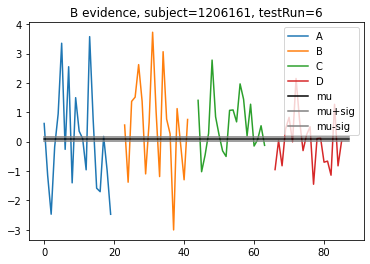

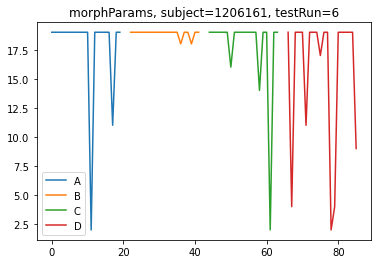

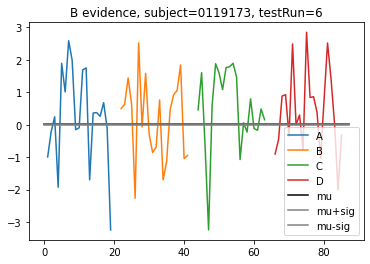

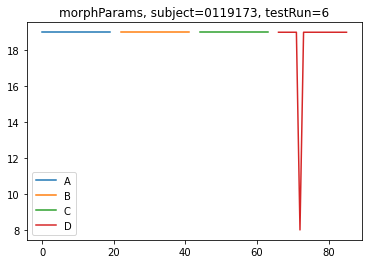

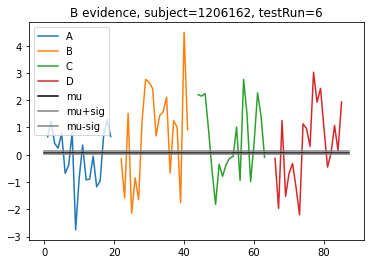

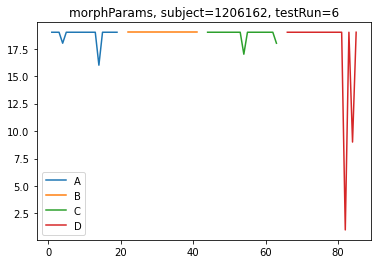

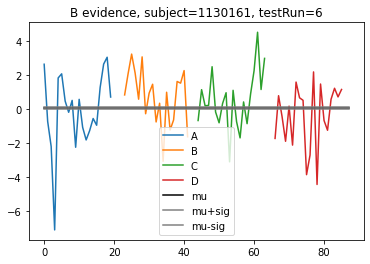

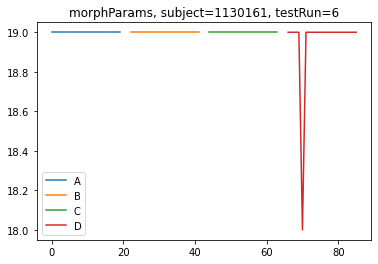

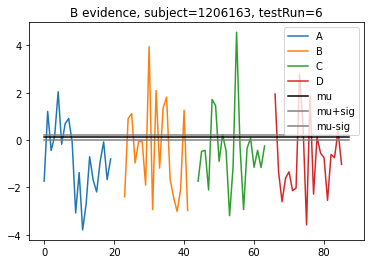

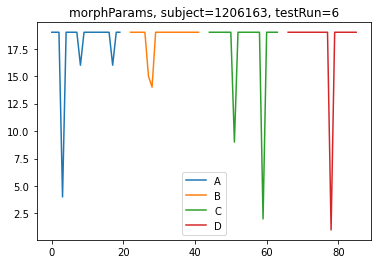

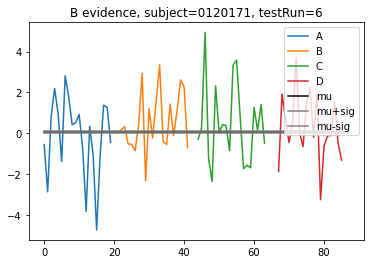

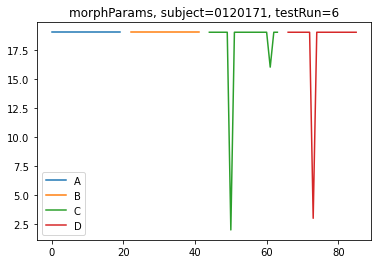

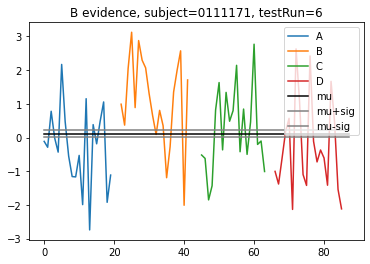

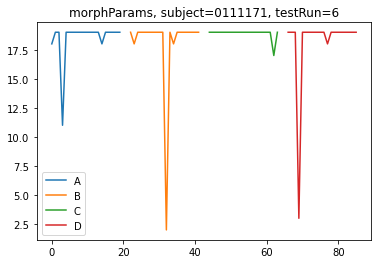

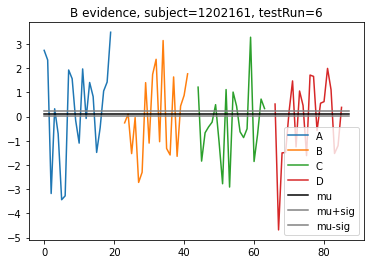

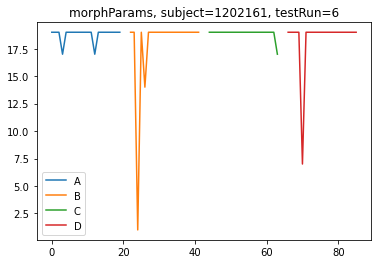

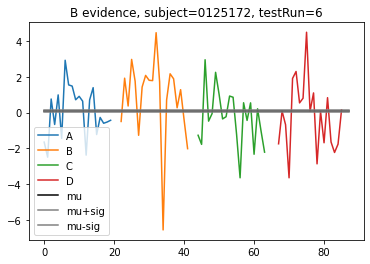

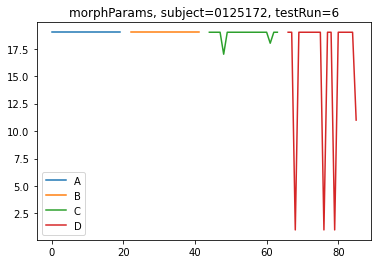

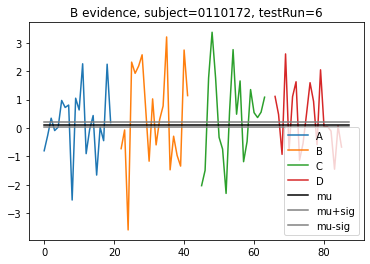

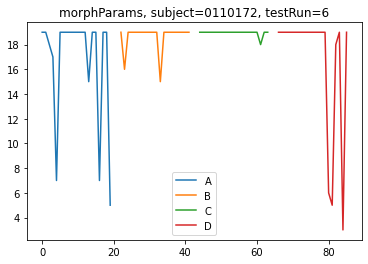

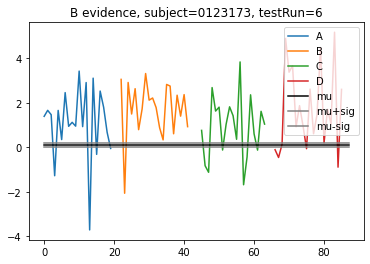

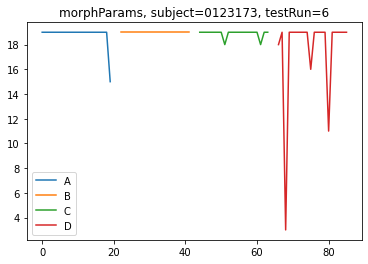

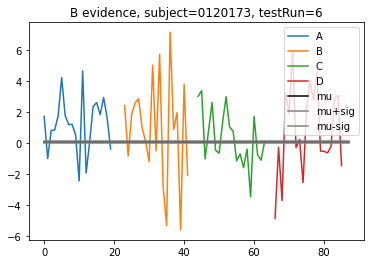

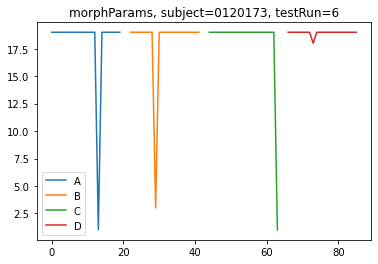

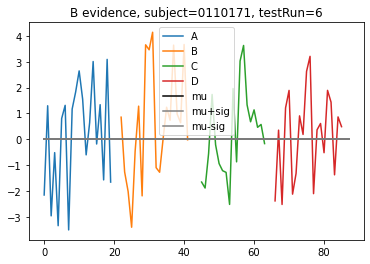

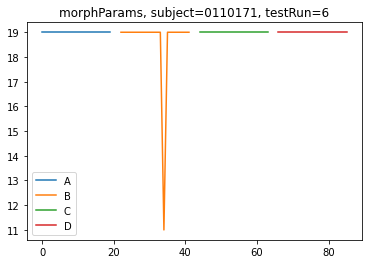

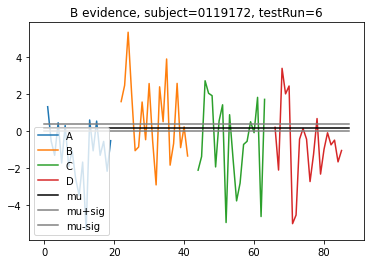

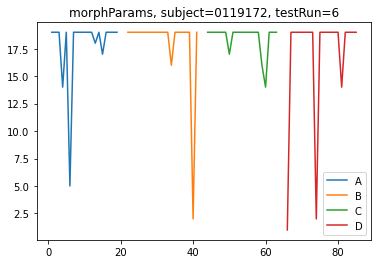

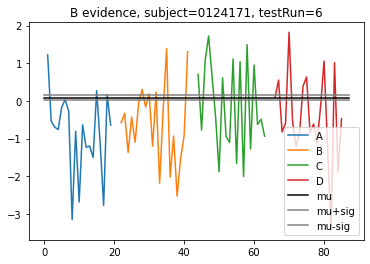

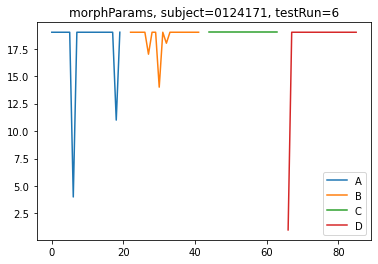

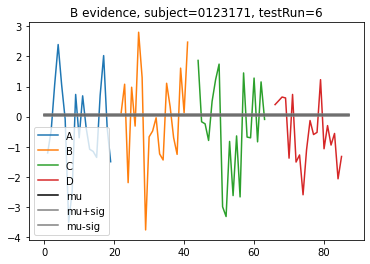

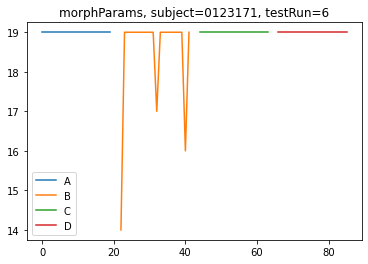

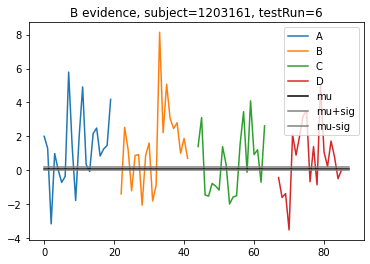

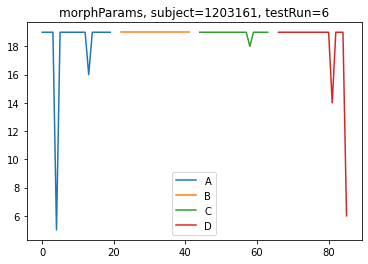

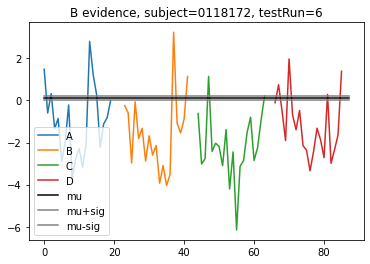

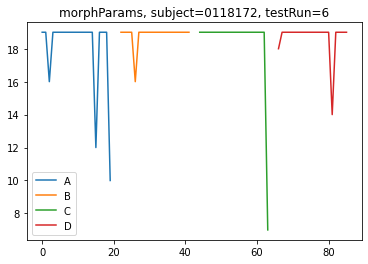

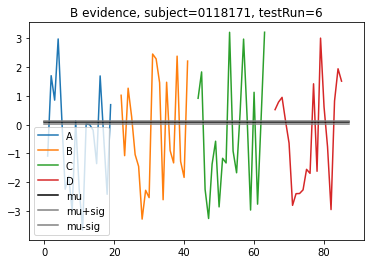

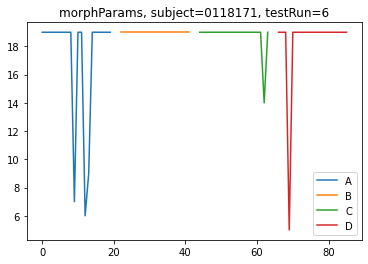

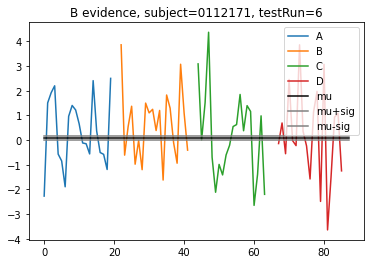

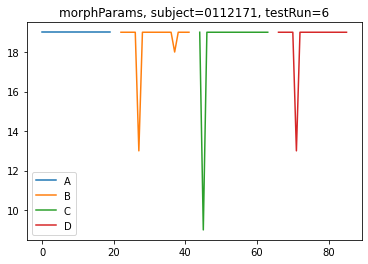

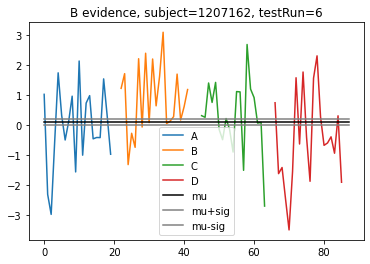

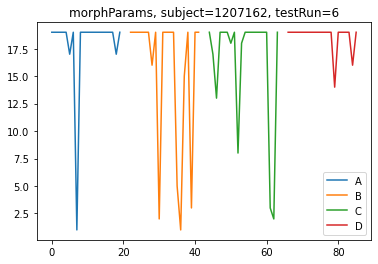

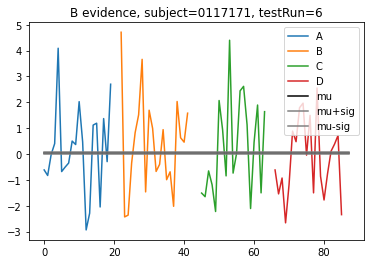

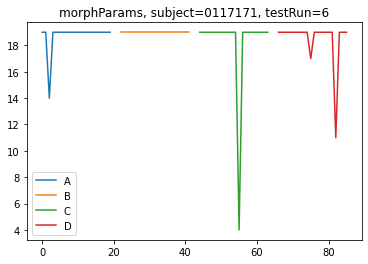

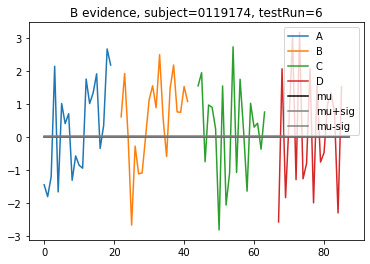

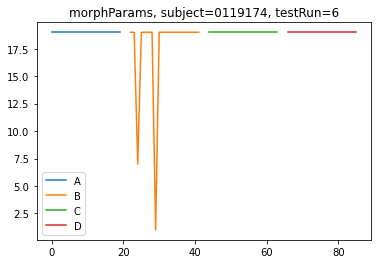

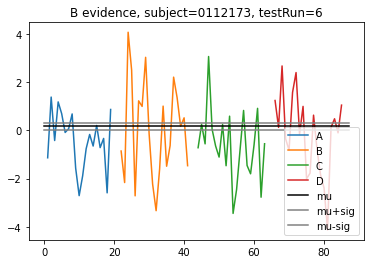

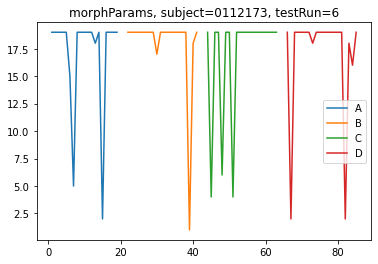

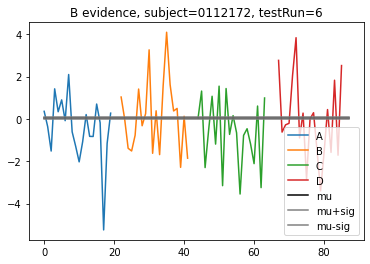

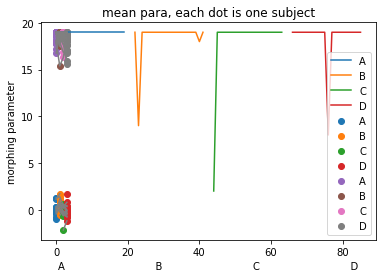

In [101]:
'''
这个code的目的是用neurosketch 的数据来检测现在在realtime data里面发现的issue：也就是ceiling有时候竟然比floor更小
这个code的运行逻辑是
用neurosketch前五个run训练2 way classifiers，然后用最后一个run来计算ceiling和floor的值，看是否合理
'''


'''
purpose:
    find the best performed mask from the result of aggregate_greedy.py and save as chosenMask
    train all possible pairs of 2way classifiers and save for evidence calculation
    load saved classifiers and calculate different forms of evidence
steps:
    load the result of aggregate_greedy.py
    display the result of aggregate_greedy.py
    find the best performed ROI for each subject and display the accuracy of each subject, save the best performed ROI as chosenMask
    load the functional and behavior data and choseMask and train all possible pairs of 2way classifiers
    calculate the evidence floor and ceil for each subject and display different forms of evidences.
    

'''




'''
load the result of aggregate_greedy.py
'''
# To visualize the greedy result starting for 31 ROIs, in total 25 subjects.
import os
os.chdir("/gpfs/milgram/project/turk-browne/projects/rtTest/kp_scratch/")
from glob import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle5 as pickle
import subprocess
import numpy as np
import os
print(f"conda env={os.environ['CONDA_DEFAULT_ENV']}") 
import numpy as np
import nibabel as nib
import sys
import time
import pandas as pd
from sklearn.linear_model import LogisticRegression
import itertools
import subprocess
from subprocess import call
import warnings
warnings.filterwarnings("ignore")

workingDir="/gpfs/milgram/project/turk-browne/projects/rtTest/"
def logit(p):
    return np.log(p/(1-p))
def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
roiloc="schaefer2018"
dataSource="neurosketch"
subjects_correctly_aligned=['1206161','0119173','1206162','1130161','1206163','0120171','0111171','1202161','0125172','0110172','0123173','0120173','0110171','0119172','0124171','0123171','1203161','0118172','0118171','0112171','1207162','0117171','0119174','0112173','0112172']
subjects=subjects_correctly_aligned
N=78
workingPath="/gpfs/milgram/project/turk-browne/projects/rtTest/"
GreedyBestAcc=np.zeros((len(subjects),N+1))
GreedyBestAcc[GreedyBestAcc==0]=None
GreedyBestAcc={}
numberOfROIs={}
tag="GM"
for ii,subject in enumerate(subjects):
    # try:
    #     GreedyBestAcc[ii,N]=np.load(workingPath+"./{}/{}/output/uniMaskRanktag2_top{}.npy".format(roiloc, subject, N))
    # except:
    #     pass
    t=np.load(workingPath+f"./{roiloc}/{subject}/output/uniMaskRank_{tag}_top{N}.npy")
    GreedyBestAcc[subject]=[np.float(t)]
    numberOfROIs[subject]=[N]
    # for len_topN_1 in range(N-1,0,-1):
    for len_topN in range(1,N):
        # Wait(f"./tmp/{subject}_{N}_{roiloc}_{dataSource}_{len_topN_1}.pkl")
        try:
            # {当前的被试}_{greedy开始的ROI数目，也就是25}_{mask的种类schaefer2018}_{数据来源neurosketch}_{当前的 megaROI 包含有的数目}
            di = load_obj(f"./tmp__folder/{subject}_{N}_{roiloc}_{dataSource}_{len_topN}")
            GreedyBestAcc[subject].append(np.float(di['bestAcc']))
            numberOfROIs[subject].append(len_topN)
            # GreedyBestAcc[ii,len_topN] = di['bestAcc']
        except:
            pass


# '''
# to load the imtermediate results from greedy code to examine the system
# '''
# def wait(tmpFile):
#     while not os.path.exists(tmpFile+'_result.npy'):
#         time.sleep(5)
#         print(f"waiting for {tmpFile}_result.npy\n")
#     return np.load(tmpFile+'_result.npy')

# subject= '0119173' #sys.argv[1]
# sub_id = [i for i,x in enumerate(subjects) if x == subject][0]
# intermediate_result=np.zeros((N+1,N+1))
# # 应该有多少？25个24ROI，2个1ROI，24个
# for i in range(N,1,-1):
#     for j in range(i):
#         tmpFile=f"./tmp__folder/{subject}_{N}_{roiloc}_{dataSource}_{i}_{j}"
#         sl_result=wait(tmpFile)
#         intermediate_result[i,j]=sl_result

# # _=plt.imshow(intermediate_result)
# #最后一行是25个24ROI，第2行是2个1ROI

'''
display the result of aggregate_greedy.py
'''
# GreedyBestAcc=GreedyBestAcc.T
# plt.imshow(GreedyBestAcc)
# _=plt.figure()
# for i in range(GreedyBestAcc.shape[0]):
#     plt.scatter([i]*GreedyBestAcc.shape[1],GreedyBestAcc[i,:],c='g',s=2)
# plt.plot(np.arange(GreedyBestAcc.shape[0]),np.nanmean(GreedyBestAcc,axis=1))
# # plt.ylim([0.19,0.36])
# # plt.xlabel("number of ROIs")
# # plt.ylabel("accuracy")
# _=plt.figure()
# for j in range(GreedyBestAcc.shape[1]):
#     plt.plot(GreedyBestAcc[:,j])


# GreedyBestAcc=GreedyBestAcc.T
# _=plt.figure()
# plt.imshow(GreedyBestAcc)

'''
find the best performed ROI for each subject and display the accuracy of each subject, save the best performed ROI as chosenMask
'''
#find best ID for each subject
bestID={}
for ii,subject in enumerate(subjects):
    t=GreedyBestAcc[subject]
    bestID[subject] = numberOfROIs[subject][np.where(t==np.nanmax(t))[0][0]] #bestID 指的是每一个subject对应的最好的megaROI包含的ROI的数目
chosenMask={}
for subject in bestID:
    # best ID  
    # {当前的被试}_{greedy开始的ROI数目，也就是25}_{mask的种类schaefer2018}_{数据来源neurosketch}_{最好的megaROI 包含有的数目}
    di = load_obj(f"./tmp__folder/{subject}_{N}_{roiloc}_{dataSource}_{bestID[subject]}")
    chosenMask[subject] = di['bestROIs']
    print(f"di['bestROIs']={di['bestROIs']}")

def getMask(topN, subject):
    workingDir="/gpfs/milgram/project/turk-browne/projects/rtTest/"
    for pn, parc in enumerate(topN):
        _mask = nib.load(workingDir+"/{}/{}/{}".format(roiloc, subject, parc))
        aff = _mask.affine
        _mask = _mask.get_data()
        _mask = _mask.astype(int)
        # say some things about the mask.
        mask = _mask if pn == 0 else mask + _mask
        mask[mask>0] = 1
    return mask

for sub in chosenMask:
    mask=getMask(chosenMask[sub], sub)
    # if not os.path.exists(f"{workingDir}/{roiloc}/{sub}/chosenMask.npy"):
    np.save(f"{workingDir}/{roiloc}/{sub}/chosenMask_{tag}",mask)
    

from scipy.stats import zscore
def normalize(X):
    _X=X.copy()
    _X = zscore(_X, axis=0)
    _X[np.isnan(_X)]=0
    return _X

def mkdir(folder):
    if not os.path.isdir(folder):
        os.mkdir(folder)

'''
calculate the evidence floor and ceil for each subject and display different forms of evidences.
'''
def morphingTarget(subject,testRun=6):
    '''
    purpose:
        get the morphing target function
    steps:
        load train clf
        load brain data and behavior data
        get the morphing target function
            evidence_floor is C evidence for CD classifier(can also be D evidence for CD classifier)
            evidence_ceil  is A evidence in AC and AD classifier
    '''

    import os
    import numpy as np
    import pandas as pd
    import joblib
    import nibabel as nib


    phasedict = dict(zip([1,2,3,4,5,6],["12", "12", "34", "34", "56", "56"]))
    imcodeDict={"A": "bed", "B": "Chair", "C": "table", "D": "bench"}
    if 'milgram' in os.getcwd():
        main_dir='/gpfs/milgram/project/turk-browne/projects/rtTest/'
    else:
        main_dir='/Users/kailong/Desktop/rtTest'

    working_dir=main_dir
    os.chdir(working_dir)

    funcdata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/{sub}_neurosketch/data/nifti/realtime_preprocessed/{sub}_neurosketch_recognition_run_{run}.nii.gz"
    metadata = "/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/data/features/recog/metadata_{sub}_V1_{phase}.csv"

    metas = []

    run=testRun
    print(run, end='--')
    # retrieve from the dictionary which phase it is, assign the session
    phase = phasedict[run]
    ses = 1
    
    # Build the path for the preprocessed functional data
    this4d = funcdata.format(ses=ses, run=run, phase=phase, sub=subject)
    
    # Read in the metadata, and reduce it to only the TR values from this run, add to a list
    thismeta = pd.read_csv(metadata.format(ses=ses, run=run, phase=phase, sub=subject))
    if dataSource == "neurosketch":
        _run = 1 if run % 2 == 0 else 2
    else:
        _run = run
    thismeta = thismeta[thismeta['run_num'] == int(_run)]
    
    if dataSource == "realtime":
        TR_num = list(thismeta.TR.astype(int))
        labels = list(thismeta.Item)
        labels = [imcodeDict[label] for label in labels]
    else:
        TR_num = list(thismeta.TR_num.astype(int))
        labels = list(thismeta.label)
    
    print("LENGTH OF TR: {}".format(len(TR_num)))
    # Load the functional data
    runIm = nib.load(this4d)
    affine_mat = runIm.affine
    runImDat = runIm.get_fdata()
    
    # Use the TR numbers to select the correct features
    features = [runImDat[:,:,:,n+3] for n in TR_num]
    features = np.array(features)
    chosenMask = np.load(f"/gpfs/milgram/project/turk-browne/projects/rtTest/schaefer2018/{subject}/chosenMask_{tag}.npy")
    features = features[:, chosenMask==1]
    print("shape of features", features.shape, "shape of chosenMask", chosenMask.shape)
    # featmean = features.mean(1).mean(1).mean(1)[..., None,None,None] #features.mean(1)[..., None]
    # features = features - featmean
    # features = features - features.mean(0)
    def RTnormalize(features):
        raw = np.expand_dims(features[0], 0)
        acc_norm_data=raw
        for curr_TR in range(1,features.shape[0]):
            raw = np.concatenate((raw,np.expand_dims(features[curr_TR],0)),axis=0)
            raw_normalized=raw.copy()
            raw_normalized=normalize(raw_normalized)
            acc_norm_data = np.concatenate((acc_norm_data,np.expand_dims(raw_normalized[-1],0)),axis=0)
            print(acc_norm_data.shape)
        return acc_norm_data

    features = RTnormalize(features)
    # features = np.expand_dims(features, 0)
    
    # Append both so we can use it later
    # metas.append(labels)
    # metas['label']

    t=pd.DataFrame()
    t['label']=labels
    t["run_num"]=run
    behav_data=t
    
    runs = features

    
    dimsize = runIm.header.get_zooms()
    
    brain_data = runs
    print(brain_data.shape)
    print(behav_data.shape)
    FEAT=brain_data
    print(f"FEAT.shape={FEAT.shape}")
    META=behav_data

    # convert item colume to label colume
    imcodeDict={
    'A': 'bed',
    'B': 'chair',
    'C': 'table',
    'D': 'bench'}


    # def classifierEvidence(clf,X,Y):
    #     ID=np.where((clf.classes_==Y)*1==1)[0][0]
    #     Evidence=(X@clf.coef_.T+clf.intercept_) if ID==1 else (-(X@clf.coef_.T+clf.intercept_))
    #     # Evidence=(X@clf.coef_.T+clf.intercept_) if ID==0 else (-(X@clf.coef_.T+clf.intercept_))
    #     return np.asarray(Evidence)

    def classifierEvidence(clf,X,Y):
        ID=np.where((clf.classes_==Y)*1==1)[0][0]
        p = clf.predict_proba(X)[:,ID]
        BX=np.log(p/(1-p))
        return BX

    def classifierProb(clf,X,Y):
        ID=np.where((clf.classes_==Y)*1==1)[0][0]
        p = clf.predict_proba(X)[:,ID]
        return p
    # imcodeDict={
    # 'A': 'bed',
    # 'B': 'chair',
    # 'C': 'table',
    # 'D': 'bench'}
    A_ID = (META['label']=='bed')
    X_A = FEAT[A_ID]

    B_ID = (META['label']=='chair')
    X_B = FEAT[B_ID]

    C_ID = (META['label']=='table')
    X_C = FEAT[C_ID]

    D_ID = (META['label']=='bench')
    X_D = FEAT[D_ID]


    model_folder = f"{working_dir}{roiloc}/{subject}/clf/"
    ceilings={'1206161': 0.1704018019671017,
    '0119173': 0.015473825479978038,
    '1206162': 0.156277891292176,
    '1130161': 0.1234585334065389,
    '1206163': 0.23871839204563827,
    '0120171': 0.09837705349563342,
    '0111171': 0.23528731137622036,
    '1202161': 0.23130485589191493,
    '0125172': 0.13846164383941578,
    '0110172': 0.23388283785077046,
    '0123173': 0.20108707419544591,
    '0120173': 0.1512688639136599,
    '0110171': 0.02098889405777557,
    '0119172': 0.40217563355892294,
    '0124171': 0.15899675598518231,
    '0123171': 0.10188696143122584,
    '1203161': 0.19378255742049785,
    '0118172': 0.24137653795983605,
    '0118171': 0.15063441599697375,
    '0112171': 0.1675121356064939,
    '1207162': 0.2332026859351661,
    '0117171': 0.10311784816750072,
    '0119174': 0.03493032693679105,
    '0112173': 0.3324759723502478,
    '0112172': 0.08287185584068701}
    ceil=ceilings[subject]
    floor=0
    mu = (ceil+floor)/2
    sig = (ceil-floor)/2.3548
    print(f"floor={floor}, ceil={ceil}")
    print(f"mu={mu}, sig={sig}")


    BC_clf=joblib.load(model_folder +'benchchair_chairtable.joblib') # These 4 clf are the same: bedbench_benchtable.joblib bedtable_tablebench.joblib benchchair_benchtable.joblib chairtable_tablebench.joblib
    BD_clf=joblib.load(model_folder +'bedchair_chairbench.joblib') # These 4 clf are the same: bedbench_benchtable.joblib bedtable_tablebench.joblib benchchair_benchtable.joblib chairtable_tablebench.joblib
    def gaussian(x, mu, sig):
        # mu and sig is determined before each neurofeedback session using 2 recognition runs.
        return np.round(1+18*(1 - np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.))))) # map from (-∞,∞) -> [1,19]

    def BEvi(X):
        # print(f"classifierEvidence(BC_clf,X,Y)={classifierEvidence(BC_clf,X,Y)}")
        # print(f"classifierEvidence(BD_clf,X,Y)={classifierEvidence(BD_clf,X,Y)}")
        BC_B_evidence = classifierEvidence(BC_clf,X,'chair')
        BD_B_evidence = classifierEvidence(BD_clf,X,'chair')
        # print(f"BC_B_evidence={BC_B_evidence}")
        # print(f"BD_B_evidence={BD_B_evidence}")
        B_evidence = (BC_B_evidence+BD_B_evidence)/2
        morphParam=gaussian(B_evidence, mu, sig)
        return B_evidence , morphParam
            
    B_evidences , morphParams=[],[]
    for X in [X_A,X_B,X_C,X_D]:
        B_evidence , morphParam = BEvi(X)
        B_evidences.append(B_evidence) 
        morphParams.append(morphParam)

    plt.figure()
    start=0
    for i,label in enumerate(["A","B","C","D"]):
        plt.plot(np.arange(start,start+len(B_evidences[i])) , B_evidences[i],label=label)
        start=start+len(B_evidences[i])+2
    plt.plot(np.arange(0,start),len(np.arange(0,start))*[mu],label="mu",c="black")
    plt.plot(np.arange(0,start),len(np.arange(0,start))*[mu+sig],label="mu+sig",c="grey")
    plt.plot(np.arange(0,start),len(np.arange(0,start))*[mu-sig],label="mu-sig",c="grey")
    plt.legend()
    plt.title(f"B evidence, subject={subject}, testRun={testRun}")

    plt.figure()
    start=0
    for i,label in enumerate(["A","B","C","D"]):
        plt.plot(np.arange(start,start+len(morphParams[i])) , morphParams[i],label=label)
        start=start+len(morphParams[i])+2
    plt.legend()
    plt.title(f"morphParams, subject={subject}, testRun={testRun}")


    # store="\n"
    # print("floor")
    # # D evidence for AD_clf when A is presented.
    # Y = 'bench'
    # AD_clf=joblib.load(model_folder +'bedchair_bedbench.joblib') # These 4 clf are the same:   bedchair_bedbench.joblib bedtable_bedbench.joblib benchchair_benchbed.joblib benchtable_benchbed.joblib
    # AD_D_evidence = classifierProb(AD_clf,X,Y)
    # evidence_floor = np.mean(AD_D_evidence)
    # print(f"D evidence for AD_clf when A is presented={evidence_floor}")
    # store=store+f"D evidence for AD_clf when A is presented={evidence_floor}"

    # # C evidence for AC_clf when A is presented.
    # Y = 'table'
    # AC_clf=joblib.load(model_folder +'benchtable_tablebed.joblib') # These 4 clf are the same:   bedbench_bedtable.joblib bedchair_bedtable.joblib benchtable_tablebed.joblib chairtable_tablebed.joblib
    # AC_C_evidence = classifierProb(AC_clf,X,Y)
    # evidence_floor = np.mean(AC_C_evidence)
    # print(f"C evidence for AC_clf when A is presented={evidence_floor}")
    # store=store+"\n"+f"C evidence for AC_clf when A is presented={evidence_floor}"

    # # D evidence for CD_clf when A is presented.
    # Y = 'bench'
    # CD_clf=joblib.load(model_folder +'bedbench_benchtable.joblib') # These 4 clf are the same: bedbench_benchtable.joblib bedtable_tablebench.joblib benchchair_benchtable.joblib chairtable_tablebench.joblib
    # CD_D_evidence = classifierProb(CD_clf,X,Y)
    # evidence_floor1 = np.mean(CD_D_evidence)
    # print(f"D evidence for CD_clf when A is presented={evidence_floor1}")
    # store=store+"\n"+f"D evidence for CD_clf when A is presented={evidence_floor1}"

    # # C evidence for CD_clf when A is presented.
    # Y = 'table'
    # CD_clf=joblib.load(model_folder +'bedbench_benchtable.joblib') # These 4 clf are the same: bedbench_benchtable.joblib bedtable_tablebench.joblib benchchair_benchtable.joblib chairtable_tablebench.joblib
    # CD_C_evidence = classifierProb(CD_clf,X,Y)
    # evidence_floor2 = np.mean(CD_C_evidence)
    # print(f"C evidence for CD_clf when A is presented={evidence_floor2}")
    # store=store+"\n"+f"C evidence for CD_clf when A is presented={evidence_floor2}"

    # # set floor to be 0, (aka before inverting is 0.5) and only estimate ceiling # edited 03152021
    # evidence_floor = 0.5 #max(evidence_floor1,evidence_floor2)
    # store=store+f"\nmax(evidence_floor1,evidence_floor2)={evidence_floor} unique_Mark"


    # print("ceil")
    # store=store+"\n"+"ceil"
    # # evidence_ceil  is A evidence in AC and AD classifier
    # Y = 'bed'
    # AC_clf=joblib.load(model_folder +'benchtable_tablebed.joblib') # These 4 clf are the same:   bedbench_bedtable.joblib bedchair_bedtable.joblib benchtable_tablebed.joblib chairtable_tablebed.joblib
    # AC_A_evidence = classifierProb(AC_clf,X,Y)
    # evidence_ceil1 = AC_A_evidence
    # print(f"A evidence in AC_clf when A is presented={np.mean(evidence_ceil1)}")
    # store=store+"\n"+f"A evidence in AC_clf when A is presented={np.mean(evidence_ceil1)}"

    # Y = 'bed'
    # AD_clf=joblib.load(model_folder +'bedchair_bedbench.joblib') # These 4 clf are the same:   bedchair_bedbench.joblib bedtable_bedbench.joblib benchchair_benchbed.joblib benchtable_benchbed.joblib
    # AD_A_evidence = classifierProb(AD_clf,X,Y)
    # evidence_ceil2 = AD_A_evidence
    # print(f"A evidence in AD_clf when A is presented={np.mean(evidence_ceil2)}")
    # store=store+"\n"+f"A evidence in AD_clf when A is presented={np.mean(evidence_ceil2)}"

    # # evidence_ceil = np.mean(evidence_ceil1)
    # # evidence_ceil = np.mean(evidence_ceil2)
    # evidence_ceil = np.mean((evidence_ceil1+evidence_ceil2)/2)
    # print(f"evidence_ceil={evidence_ceil} uniqueMark")
    # store=store+f"\nevidence_ceil={evidence_ceil} uniqueMark"

    # ceil,floor=logit(evidence_ceil),logit(evidence_floor)
    # mu = (ceil+floor)/2
    # sig = (ceil-floor)/2.3548
    # print(f"floor={floor}, ceil={ceil}")
    # print(f"mu={mu}, sig={sig}")

    # store=store+"\n"+f"floor={floor}, ceil={ceil}"
    # store=store+"\n"+f"mu={mu}, sig={sig}"


    # BC_clf=joblib.load(model_folder +'benchchair_chairtable.joblib') # These 4 clf are the same: bedbench_benchtable.joblib bedtable_tablebench.joblib benchchair_benchtable.joblib chairtable_tablebench.joblib
    # BD_clf=joblib.load(model_folder +'bedchair_chairbench.joblib') # These 4 clf are the same: bedbench_benchtable.joblib bedtable_tablebench.joblib benchchair_benchtable.joblib chairtable_tablebench.joblib
    # Y = 'chair'
    # # imcodeDict={
    # # 'A': 'bed',
    # # 'B': 'chair',
    # # 'C': 'table',
    # # 'D': 'bench'}
    # print(f"classifierProb(BC_clf,FEAT,Y)={classifierProb(BC_clf,FEAT,Y)}")
    # print(f"classifierProb(BD_clf,FEAT,Y)={classifierProb(BD_clf,FEAT,Y)}")


    # # # convert item colume to label colume
    # # imcodeDict={
    # # 'A': 'bed',
    # # 'B': 'chair',
    # # 'C': 'table',
    # # 'D': 'bench'}
    # def testMorphParamFor(A): #A='bed''chair'...
    #     A_ID = (META['label']==A)
    #     X = FEAT[A_ID]


    #     # 这里的X是选择的testRun里面的所有的展示A的trials
    #     BC_B_evidence = classifierProb(BC_clf,X,Y)
    #     BD_B_evidence = classifierProb(BD_clf,X,Y)
    #     print(f"BC_B_evidence={BC_B_evidence}")
    #     print(f"BD_B_evidence={BD_B_evidence}")
    #     B_evidence = (BC_B_evidence+BD_B_evidence)/2
    #     print(f"B_evidence={B_evidence}")
    #     print(f"mu={mu}, sig={sig}")
        



    #     morphParam=np.mean(gaussian(B_evidence, mu, sig))
    #     # B_evidences.append(B_evidence)
    #     print(f"morphParam={morphParam}")
    #     return f"morphParam for {A} = {morphParam}"

    # store=store+"\n"+testMorphParamFor('bed')
    # store=store+"\n"+testMorphParamFor('chair')
    # store=store+"\n"+testMorphParamFor('table')
    # store=store+"\n"+testMorphParamFor('bench')

    return B_evidences,morphParams

Evidence={}
for sub in subjects:
    Evidence[sub] = morphingTarget(sub)

# 画evidence的总结图
plt.figure()
mean_evidence=np.zeros((len(subjects),4))
# sub="1206161"
# ii=0
for ii,sub in enumerate(subjects):
    mean_evidence[ii]=[np.mean(evidence) for evidence in Evidence[sub][0]]
mean_evidence
for i,label in enumerate(["A","B","C","D"]):
    plt.scatter([i]*(len(subjects)),mean_evidence[:,i],label=label)

plt.legend()
plt.title("mean evidence, each dot is one subject")
plt.xlabel("A                             B                             C                             D")                 
plt.ylabel("B evidence")

for ii,sub in enumerate(subjects):
    plt.plot([0,1,2,3],mean_evidence[ii],c="grey")

# 画morphing parameter的总结图
plt.figure()
mean_para=np.zeros((len(subjects),4))
# sub="1206161"
# ii=0
for ii,sub in enumerate(subjects):
    mean_para[ii]=[np.mean(para) for para in Evidence[sub][1]]
mean_para
for i,label in enumerate(["A","B","C","D"]):
    plt.scatter([i]*(len(subjects)),mean_para[:,i],label=label)

plt.legend()
plt.title("mean para, each dot is one subject")
plt.xlabel("A                             B                             C                             D")                 
plt.ylabel("morphing parameter")

for ii,sub in enumerate(subjects):
    plt.plot([0,1,2,3],mean_para[ii],c="grey")


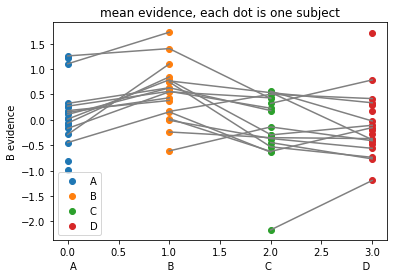

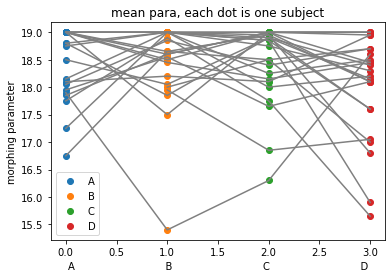

In [124]:

# 画evidence的总结图
plt.figure()
mean_evidence=np.zeros((len(subjects),4))
# sub="1206161"
# ii=0
for ii,sub in enumerate(subjects):
    mean_evidence[ii]=[np.mean(evidence) for evidence in Evidence[sub][0]]
mean_evidence
for i,label in enumerate(["A","B","C","D"]):
    plt.scatter([i]*(len(subjects)),mean_evidence[:,i],label=label)

plt.legend()
plt.title("mean evidence, each dot is one subject")
plt.xlabel("A                             B                             C                             D")                 
plt.ylabel("B evidence")

for ii,sub in enumerate(subjects):
    plt.plot([0,1,2,3],mean_evidence[ii],c="grey")

# 画morphing parameter的总结图
plt.figure()
mean_para=np.zeros((len(subjects),4))
# sub="1206161"
# ii=0
for ii,sub in enumerate(subjects):
    mean_para[ii]=[np.mean(para) for para in Evidence[sub][1]]
mean_para
for i,label in enumerate(["A","B","C","D"]):
    plt.scatter([i]*(len(subjects)),mean_para[:,i],label=label)

plt.legend()
plt.title("mean para, each dot is one subject")
plt.xlabel("A                             B                             C                             D")                 
plt.ylabel("morphing parameter")

for ii,sub in enumerate(subjects):
    plt.plot([0,1,2,3],mean_para[ii],c="grey")


In [123]:
array=np.arange(100).reshape(10,10)
print(array)


# import random
# array=array.T
# random.shuffle(array)
# array=array.T

def shuffleWithinEachRow(array):
    new=np.zeros(array.shape)
    for i in range(array.shape[0]):
        t=list(array[i])
        random.shuffle(t)
        new[i]=t
    return new

array=shuffleWithinEachRow(array)
print(array)

[[ 0  1  2  3  4  5  6  7  8  9]
 [10 11 12 13 14 15 16 17 18 19]
 [20 21 22 23 24 25 26 27 28 29]
 [30 31 32 33 34 35 36 37 38 39]
 [40 41 42 43 44 45 46 47 48 49]
 [50 51 52 53 54 55 56 57 58 59]
 [60 61 62 63 64 65 66 67 68 69]
 [70 71 72 73 74 75 76 77 78 79]
 [80 81 82 83 84 85 86 87 88 89]
 [90 91 92 93 94 95 96 97 98 99]]
[[ 3.  7.  9.  2.  4.  5.  1.  8.  0.  6.]
 [11. 17. 18. 16. 15. 13. 19. 10. 14. 12.]
 [26. 27. 23. 20. 25. 29. 22. 21. 24. 28.]
 [31. 34. 38. 32. 35. 33. 36. 37. 30. 39.]
 [47. 46. 40. 42. 43. 45. 49. 48. 41. 44.]
 [57. 51. 55. 50. 52. 56. 53. 59. 54. 58.]
 [62. 60. 66. 61. 67. 69. 65. 64. 63. 68.]
 [78. 70. 73. 76. 77. 74. 72. 79. 75. 71.]
 [82. 86. 84. 80. 88. 83. 87. 85. 89. 81.]
 [91. 98. 94. 95. 99. 90. 96. 93. 97. 92.]]


In [120]:
array=np.arange(100).reshape(10,10)
t=list(array[2])


[20, 21, 22, 23, 24, 25, 26, 27, 28, 29]